<a href="https://colab.research.google.com/github/matttulio/ContinualLearningProject/blob/main/deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep Learning Project - Matteo Gallo 916114**

## **Why do we need continual learning?**
---

<p align="justify"> Classification tasks in the real world exhibit a complexity that certainly does not cater to simplicity in our lives. While we might find solace in confining ourselves indoors, shutting out external influences, and attempting to classify the MNIST dataset, this tranquility shatters when we venture into the outside world, exposing the stark realities we had managed to overlook.

<p align="justify"> However, it's in these uncharted territories beyond our comfort zones that the true essence of the challenge comes alive.

<p align="justify"> This is where our narrative takes root. Our ambitions draw us towards real-world scenarios, where we grapple with tangible situations. To truly grasp what is authentic, we must delve into the learning process.

<p align="justify"> Consider a young child just beginning to unravel the composition of the world. They observe an array of unfamiliar objects and gradually assimilate the ability to distinguish between them. Now, imagine if this young mind could only absorb ten distinct items at any given time, much like a neural network constructed to classify the MNIST dataset. Then, unexpectedly, an eleventh object enters the scene. Regrettably, a dilemma arises, as the child must discard something from their existing knowledge to accommodate the new notion.

<p align="justify"> The real marvel would lie in the ability to learn without forsaking prior knowledge. An introguing possibility, isn't it? However, let's ponder this: what if the curious toddler could solely recognize Spider-Man by his mask? What if he encountered Spider-Man with his back turned? The outcome would be an inability to identify the superhero, and worse, a potential compromise to Earth's safety. A truly distressing thought!

<p align="justify"> Now, let us shift our focus back to reality. These are the very issues we are about to delve into — specifically, the intricate challenges of 'Multi-Task' problems. In such intricate scenarios, a single model is tasked with incrementally learning distinct tasks, encompassing 'New Classes', all while adapting to evolving data representations over time, encompassing 'New Instances'.

Let's get our hands dirty!

CuDNN (CUDA Deep Neural Network library) is a GPU-accelerated library designed to improve the performance of deep learning frameworks like PyTorch by optimizing various operations commonly used in neural networks. While CuDNN can significantly speed up training, it might introduce some randomness due to its optimization techniques.

## *New Classes*
---

<p align = 'justify'> The first problem we will consider is the problem of <i>New Classes</i>. This is the case where new classes appear over time, and we want to avoid retraining our model from scratch. An example of this problem could be detecting artifacts in certain signals.
Let's say, for example, that we are working on an interferometer for gravitational waves. This is a very sensitive instrument that is capable of detecting interactions between black holes that are light years away. We are sitting in front of our monitor, and we suddenly see an event. Our first thought is that we have made a major breakthrough, and we can already feel the Nobel Prize in our hands, and hear the applause of the crowd.
However, our excitement is quickly tempered when we see another event. Something is wrong. We can't have two Nobel Prizes, can we? We go to check one of the mirrors, and we see that there is a starling nest on top of it. Now our minds are racing. We are torn between feeling like Thanos and feeling like Snow White.
But our determination is strong, so we go back to our office and build a model that can detect this artifact and remove it from the real signal. After some time, the starlings from the first nest have proliferated, and a road has been built near the laboratory. There is even a football court nearby. We keep adding new classes to our model, but it is becoming increasingly difficult and time consuming. We need a smarter approach.

Let's build a simple network that can classify between two digits of the MNIST dataset, for example 0 and 5.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
directory = '/content/drive/My Drive/Colab Notebooks/Images'
if not os.path.exists(directory):
    os.makedirs(directory)

images_dir = '/content/drive/My Drive/Colab Notebooks/Images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
import torch
import torchvision

# Set the batch size for training data
batch_size_train = 64
# Set the batch size for testing data
batch_size_test = 1000

# Set a random seed for reproducibility
random_seed = 42

# Disable cudnn optimization for result consistency
torch.backends.cudnn.enabled = False

# Set the random seed for PyTorch's random number generator
torch.manual_seed(random_seed)


# Define a series of transformations to be applied to the data
transform = torchvision.transforms.Compose([
    # Convert the data to tensors
    torchvision.transforms.ToTensor(),
    # Normalize the data using a mean of 0.5 and a standard deviation of 0.5
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


# Create a training dataset using the MNIST dataset from the torchvision library
train_dataset = torchvision.datasets.MNIST('./data', train = True, download = True, transform = transform)
# Create a testing dataset using the MNIST dataset
test_dataset = torchvision.datasets.MNIST('./data', train = False, download = True, transform = transform)

# Initialize a data loader for the training dataset
# This loader allows batch-wise loading of data during training, with shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size_train, shuffle = True)

# Initialize a data loader for the testing dataset
# This loader allows batch-wise loading of data during testing, with shuffling
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size_test, shuffle = True)


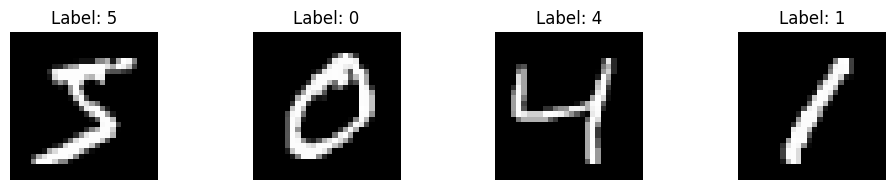

(28, 28)


In [ ]:
import matplotlib.pyplot as plt

num_images = 4

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, num_images, figsize = (10, 2))

# Loop through the first few images and display them
for i in range(num_images):
    image, label = train_dataset[i]

    # Convert the tensor to a NumPy array
    image = image.numpy()[0]

    # Plot the image
    axes[i].imshow(image, cmap = 'gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
print(image.shape)

In [ ]:
# Import the 'copy' module for deep copying objects
import copy

# Create boolean masks for target values 0 and 5 in the training dataset
idx_0 = train_dataset.targets == 0
idx_5 = train_dataset.targets == 5

# Combine the boolean masks using a logical OR operation
idx = idx_0 | idx_5

# Print the number of occurrences of class 0 in the training dataset
print(idx_0.nonzero().shape)

# Print the number of occurrences of class 5 in the training dataset
print(idx_5.nonzero().shape)

# Print the number of samples in the combined classes (0 and 5)
print(idx.nonzero().shape)

# Create a deep copy of the original training dataset
train_dataset_05 = copy.deepcopy(train_dataset)

# Update the target labels of the new dataset so that they are 0 and 1
train_dataset_05.targets = train_dataset_05.targets[idx]

train_dataset_05.targets[train_dataset_05.targets == 5] = 1

# Update the data of the new dataset by selecting samples with indices in 'idx'
train_dataset_05.data = train_dataset_05.data[idx]

# Create a DataLoader for the modified training dataset with combined classes
train_loader_05 = torch.utils.data.DataLoader(train_dataset_05, batch_size = batch_size_train, shuffle = True)

# Repeat the process for the test dataset

# Create boolean masks for target values 0 and 5 in the test dataset
idx_0 = test_dataset.targets == 0
idx_5 = test_dataset.targets == 5

# Combine the boolean masks using a logical OR operation
idx = idx_0 | idx_5

# Print the number of occurrences of class 0 in the test dataset
print(idx_0.nonzero().shape)

# Print the number of occurrences of class 5 in the test dataset
print(idx_5.nonzero().shape)

# Print the number of samples in the combined classes (0 and 5)
print(idx.nonzero().shape)

# Create a deep copy of the original test dataset
test_dataset_05 = copy.deepcopy(test_dataset)

# Update the target labels of the new test dataset so that they are 0 and 1
test_dataset_05.targets = test_dataset_05.targets[idx]

test_dataset_05.targets[test_dataset_05.targets == 5] = 1

# Update the data of the new test dataset by selecting samples with indices in 'idx'
test_dataset_05.data = test_dataset_05.data[idx]

# Create a DataLoader for the modified test dataset with combined classes
test_loader_05 = torch.utils.data.DataLoader(test_dataset_05, batch_size = batch_size_test, shuffle = True)

torch.Size([5923, 1])
torch.Size([5421, 1])
torch.Size([11344, 1])
torch.Size([980, 1])
torch.Size([892, 1])
torch.Size([1872, 1])


In [ ]:
# Define a custom module named 'Flatten' that flattens the input tensor
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# Define a neural network architecture named 'RoosterNET'
class RoosterNET(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the network architecture using an nn.Sequential container
        self.network = torch.nn.Sequential(
              # Apply a dropout layer with a dropout probability of 0.2
            torch.nn.Conv2d(1, 4, kernel_size = 6, stride = 1, padding = 1),  # Apply a 2D convolutional layer with 1 input channel, 8 output channels, kernel size 3x3, stride 1, and padding 1
            torch.nn.Dropout2d(0.05),
            torch.nn.ReLU(),  # Apply a ReLU activation function
            torch.nn.Conv2d(4, 8, kernel_size = 6, stride = 1, padding = 1),  # Apply another convolutional layer with 8 input channels, 16 output channels, kernel size 3x3, stride 1, and padding 1
            torch.nn.ReLU(),  # Apply a ReLU activation function
            torch.nn.Conv2d(8, 16, kernel_size = 2, stride = 2, padding = 1),  # Apply another convolutional layer with 16 input channels, 32 output channels, kernel size 4x4, stride 2, and padding 1
            torch.nn.Dropout2d(0.2),
            torch.nn.ReLU(),  # Apply a ReLU activation function
            torch.nn.MaxPool2d(2, 2),  # Apply a 2x2 MaxPooling layer with stride 2
            torch.nn.Flatten(),  # Flatten the tensor using the custom 'Flatten' module

            torch.nn.Linear(576, 86),  # Apply a fully connected (linear) layer with 1792 input features and 113 output features
            torch.nn.ReLU(),  # Apply a ReLU activation function
            torch.nn.Linear(86, 2)  # Apply another linear layer with 113 input features and 1 output feature
        )

#[(W−K+2P)/S]+1. [(28 - 6 + 2 * 1) / 1] + 1 = 25
#[(W−K+2P)/S]+1. [(25 - 6 + 2 * 1) / 1] + 1 = 22
#[(W−K+2P)/S]+1. [(22 - 2 + 2 * 1) / 2] + 1 = 12
#[(W−K)/S]+1. [(12 - 2) / 2] + 1 = 6
#6 x 6 x 16

    # Define the forward pass method to compute predictions
    def forward(self, xb):
        return self.network(xb)


In [ ]:
# Import necessary module for neural network operations
import tqdm
import numpy as np

# Define the training function
def train(model, device, train_loader, optimizer, epoch):
    # Uncommenting the following line would set the model in training mode
    model.train()

    # Create a progress bar for training batches
    with tqdm.tqdm(train_loader, unit = 'batch') as tepoch:
        # Initialize a variable to track the mean loss
        running_loss = 0

        # Iterate through batches in the training loader
        for num_tepoch, (data, target) in enumerate(tepoch):

            # Move data and target tensors to the specified device (CPU or GPU)
            data, target = data.to(device), target.to(device)

            # Clear the gradients from the previous iteration
            optimizer.zero_grad()

            # Forward pass: calculate model predictions
            output = model(data)

            # Compute the cross-entropy loss between predictions and targets
            loss = torch.nn.functional.cross_entropy(output, target)

            # Backpropagation: compute gradients
            loss.backward()

            # Update model parameters using the optimizer
            optimizer.step()

            # Add the loss of the current batch to the mean_loss
            running_loss += loss.item()

            # Update the progress bar with the average loss for the epoch
            tepoch.set_postfix(loss = running_loss / (num_tepoch + 1))

    return running_loss


# Define the testing function
def test(model, device, test_loader):
    # Set the model in evaluation mode
    model.eval()

    # Initialize variables for test loss and correct predictions
    test_loss = 0
    correct = 0

    # Disable gradient computation during testing
    with torch.no_grad():
        # Iterate through batches in the test loader
        for data, target in test_loader:
            # Move data and target tensors to the specified device
            data, target = data.to(device), target.to(device)

            # Forward pass: calculate model predictions
            output = model(data)

            # Calculate the negative log likelihood loss and add to test_loss
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction = 'sum').item()

            # Get predicted labels by selecting the index of the maximum log-probability
            pred = output.argmax(dim = 1, keepdim = True)

            # Compare predicted labels with true labels and count correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average test loss
    test_loss /= len(test_loader.dataset)

    # Calculate accuracy as a percentage
    accuracy = 100. * correct / len(test_loader.dataset)

    # Print test results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    # Return test loss
    return np.mean(test_loss)

In [ ]:
# Set a flag to determine whether to use CUDA (GPU acceleration) or not
use_cuda = False

# Set a flag to determine whether to save the trained model or not
save_model = True

# Set the number of training epochs
epochs = 3

# Set the learning rate for the optimizer
lr = 1e-2

# Choose the computing device (CPU or GPU) based on the use_cuda flag
device = torch.device("cuda" if use_cuda else "cpu")

# Create an instance of the RoosterNET model and move it to the chosen device
model_05 = RoosterNET().to(device)

# Define the optimizer for updating the model parameters
# Here, Stochastic Gradient Descent (SGD) is used with a specified learning rate and momentum
optimizer = torch.optim.SGD(model_05.parameters(), lr = lr, momentum = 0.9)

In [ ]:
from torchsummary import summary
summary(model_05, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 25, 25]             148
         Dropout2d-2            [-1, 4, 25, 25]               0
              ReLU-3            [-1, 4, 25, 25]               0
            Conv2d-4            [-1, 8, 22, 22]           1,160
              ReLU-5            [-1, 8, 22, 22]               0
            Conv2d-6           [-1, 16, 12, 12]             528
         Dropout2d-7           [-1, 16, 12, 12]               0
              ReLU-8           [-1, 16, 12, 12]               0
         MaxPool2d-9             [-1, 16, 6, 6]               0
          Flatten-10                  [-1, 576]               0
           Linear-11                   [-1, 86]          49,622
             ReLU-12                   [-1, 86]               0
           Linear-13                    [-1, 2]             174
Total params: 51,632
Trainable params: 

In [ ]:
train_loss05 = []
test_loss05 = []

for epoch in (range(1, epochs + 1)):
    train_loss_ep = train(model_05, device, train_loader_05, optimizer, epoch)
    test_loss_ep = test(model_05, device, test_loader_05)

    train_loss05.append(train_loss_ep)
    test_loss05.append(test_loss_ep)


100%|██████████| 178/178 [00:11<00:00, 15.34batch/s, loss=0.207]



Test set: Average loss: 0.0238, Accuracy: 1856/1872 (99.15%)




100%|██████████| 178/178 [00:13<00:00, 13.41batch/s, loss=0.0211]



Test set: Average loss: 0.0174, Accuracy: 1860/1872 (99.36%)




100%|██████████| 178/178 [00:12<00:00, 14.20batch/s, loss=0.0138]



Test set: Average loss: 0.0084, Accuracy: 1864/1872 (99.57%)



              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           5       0.99      1.00      1.00       892

    accuracy                           1.00      1872
   macro avg       1.00      1.00      1.00      1872
weighted avg       1.00      1.00      1.00      1872



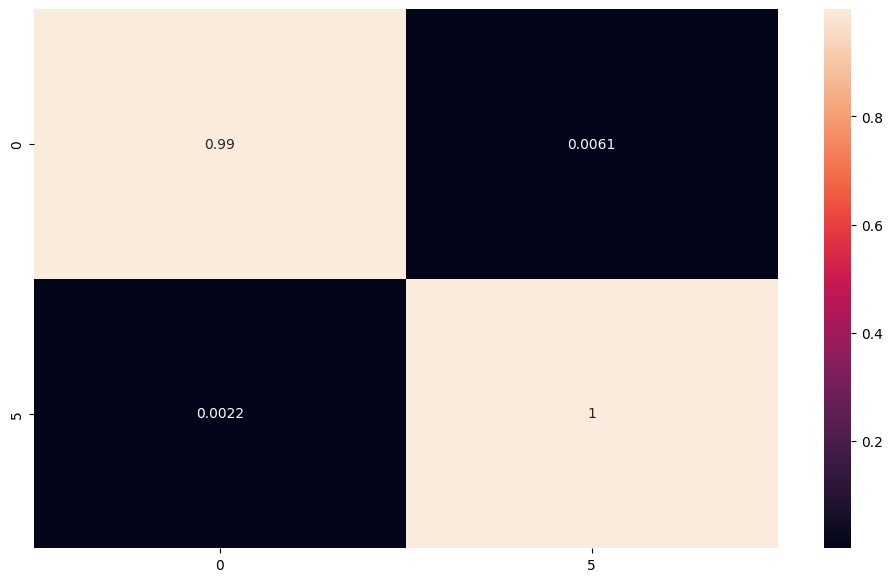

In [ ]:
# Import necessary libraries for creating a confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Import libraries for creating a heatmap visualization
import seaborn as sn
import pandas as pd

# Initialize empty lists to store predicted and target labels
pred = []
targ = []

# Iterate through the test_loader_05 using no gradient computation
with torch.no_grad():
    for inputs, targets in test_loader_05:
        # Move inputs and targets to the chosen device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Perform forward pass to get model predictions
        output = model_05(inputs)

        # Convert output into predicted class labels
        prediticted = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()

        # Extend the pred and targ lists with the new predicted and target labels
        pred.extend(prediticted)
        targ.extend(targets.data.cpu().numpy())

# Define class labels
classes = ("0", "5")

# Calculate the confusion matrix
cf_matrix = confusion_matrix(targ, pred)

# Normalize the confusion matrix
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in classes],
                     columns = [i for i in classes])

# Set up the visualization
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot = True)

# Print the classification report
print(classification_report(targ, pred, target_names = classes))

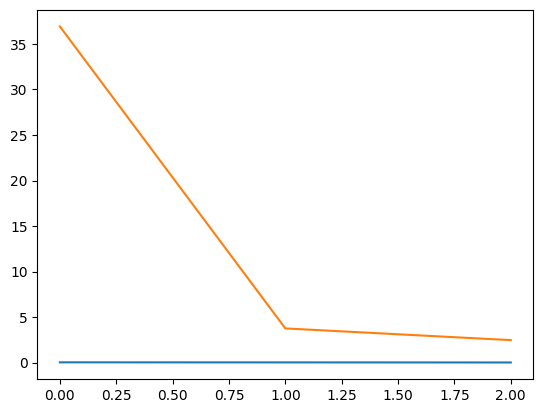

In [ ]:
plt.plot(test_loss05)
plt.plot(train_loss05)

<p align="justify"> As we saw, this is a simple cnn that can already achieve ~99% of accuracy on two digits from the MNIST dataset. The scope of this project is not to improve further the model but adress different issues. So let's take this model, change the output layer so that now we are doing classification between three classes. We choose to add the number 9

In [ ]:
idx_9 = train_dataset.targets == 9
idx = idx_9

print(idx_9.nonzero().shape)

train_dataset_9 = copy.deepcopy(train_dataset)

train_dataset_9.targets = train_dataset_9.targets[idx]
train_dataset_9.targets[train_dataset_9.targets == 9] = 2

train_dataset_9.data = train_dataset_9.data[idx]

train_loader_9 = torch.utils.data.DataLoader(train_dataset_9, batch_size = batch_size_train, shuffle = True)


idx_9 = test_dataset.targets == 9

idx = idx_9

print(idx_9.nonzero().shape)

test_dataset_9 = copy.deepcopy(test_dataset)

test_dataset_9.targets = test_dataset_9.targets[idx]
test_dataset_9.targets[test_dataset_9.targets == 9] = 2
test_dataset_9.data = test_dataset_9.data[idx]

test_loader_9 = torch.utils.data.DataLoader(test_dataset_9, batch_size = batch_size_test, shuffle = True)

torch.Size([5949, 1])
torch.Size([1009, 1])


In [ ]:
# Define a neural network architecture named 'BigRoosterNET'
class BigRoosterNET(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(1, 4, kernel_size = 6, stride = 1, padding = 1),
            torch.nn.Dropout2d(0.05),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 8, kernel_size = 6, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, kernel_size = 2, stride = 2, padding = 1),
            torch.nn.Dropout2d(0.2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),

            torch.nn.Linear(576, 86),
            torch.nn.ReLU(),
            torch.nn.Linear(86, 3)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_059 = BigRoosterNET().to(device)

<p align="justify"> We have our modified model suitable for distinguishing between three classes. The first thing that one my try to do is to train the new model with just the new data. To do this we freeze the first layers, the ones that do feature selection, supposing that they are learning how the space of hand written numbers, number 9 should be in the same space. The last layers are free to change.

In [ ]:
# Specify the number of layers you want to transfer
num_layers_to_transfer = 9

# Loop through the first num_layers_to_transfer layers and copy weights
for i in range(num_layers_to_transfer):
    model_059.network[i].load_state_dict(model_05.network[i].state_dict())

# Compare the weights of the first convolutional layer in both networks
original_weights = model_05.network[0].weight.data
transferred_weights = model_059.network[0].weight.data


weights_equal = torch.allclose(original_weights, transferred_weights)

if weights_equal:
    print("Weight transfer successful!")
else:
    print("Weight transfer not successful.")

Weight transfer successful!


In [ ]:
print(model_059)

BigRoosterNET(
  (network): Sequential(
    (0): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.05, inplace=False)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (6): Dropout2d(p=0.2, inplace=False)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=576, out_features=86, bias=True)
    (11): ReLU()
    (12): Linear(in_features=86, out_features=3, bias=True)
  )
)


In [ ]:
# Print the requires_grad attribute for each parameter in the model
for name, param in model_059.named_parameters():
    print(f"Parameter: {name}, Requires Grad: {param.requires_grad}")

Parameter: network.0.weight, Requires Grad: True
Parameter: network.0.bias, Requires Grad: True
Parameter: network.3.weight, Requires Grad: True
Parameter: network.3.bias, Requires Grad: True
Parameter: network.5.weight, Requires Grad: True
Parameter: network.5.bias, Requires Grad: True
Parameter: network.10.weight, Requires Grad: True
Parameter: network.10.bias, Requires Grad: True
Parameter: network.12.weight, Requires Grad: True
Parameter: network.12.bias, Requires Grad: True


In [ ]:
# Specify the layer index until which you want to freeze
freeze_until_layer = 5  # Assuming the Flatten layer is at index 9 in model_059

# Loop through the layers and freeze until the specified layer
for i, (name, param) in enumerate(model_059.named_parameters()):
    if i <= freeze_until_layer:
        param.requires_grad = False
    else:
        break  # Stop freezing after the specified layer

In [ ]:
# Print the requires_grad attribute for each parameter in the model
for name, param in model_059.named_parameters():
    print(f"Parameter: {name}, Requires Grad: {param.requires_grad}")

Parameter: network.0.weight, Requires Grad: False
Parameter: network.0.bias, Requires Grad: False
Parameter: network.3.weight, Requires Grad: False
Parameter: network.3.bias, Requires Grad: False
Parameter: network.5.weight, Requires Grad: False
Parameter: network.5.bias, Requires Grad: False
Parameter: network.10.weight, Requires Grad: True
Parameter: network.10.bias, Requires Grad: True
Parameter: network.12.weight, Requires Grad: True
Parameter: network.12.bias, Requires Grad: True


In [ ]:
use_cuda = False
save_model = True

epochs = 3
lr = 1e-2

device = torch.device("cuda" if use_cuda else "cpu")

# Create a list to store trainable parameters
trainable_params = [param for param in model_059.parameters() if param.requires_grad]

# Create an optimizer with trainable parameters
optimizer = torch.optim.SGD(trainable_params, lr=lr, momentum=0.9)

So now that we have our new model capable of distinguishing between three classes, the natural next move would be to feed the new data to the network.

In [ ]:
train_loss059 = []
test_loss059 = []

for epoch in (range(1, epochs + 1)):
    train_loss_ep = train(model_059, device, train_loader_9, optimizer, epoch)
    test_loss_ep = test(model_059, device, test_loader_9)

    train_loss059.append(train_loss_ep)
    test_loss059.append(test_loss_ep)


100%|██████████| 93/93 [00:04<00:00, 22.52batch/s, loss=0.0257]



Test set: Average loss: 0.0000, Accuracy: 1009/1009 (100.00%)




100%|██████████| 93/93 [00:04<00:00, 22.90batch/s, loss=2.66e-6]



Test set: Average loss: 0.0000, Accuracy: 1009/1009 (100.00%)




100%|██████████| 93/93 [00:04<00:00, 20.64batch/s, loss=5.91e-5]



Test set: Average loss: 0.0000, Accuracy: 1009/1009 (100.00%)



So it seems that on the new class the model is doing good. Let's see if the frozen weights didn't change, and also the general performance of all the three classes.

In [ ]:
# Compare the weights of the first convolutional layer in both networks
original_weights = model_05.network[5].weight.data
transferred_weights = model_059.network[5].weight.data


weights_equal = torch.allclose(original_weights, transferred_weights)

if weights_equal:
    print("Weight transfer successful!")
else:
    print("Weight transfer not successful.")

Weight transfer successful!


In [ ]:
idx_0 = train_dataset.targets == 0
idx_5 = train_dataset.targets == 5
idx_9 = train_dataset.targets == 9

idx = idx_0 | idx_5 | idx_9

print(idx_0.nonzero().shape)
print(idx_5.nonzero().shape)
print(idx_9.nonzero().shape)
print(idx.nonzero().shape)

train_dataset_059 = copy.deepcopy(train_dataset)

train_dataset_059.targets = train_dataset_059.targets[idx]
train_dataset_059.targets[train_dataset_059.targets == 5] = 1
train_dataset_059.targets[train_dataset_059.targets == 9] = 2
train_dataset_059.data = train_dataset_059.data[idx]

train_loader_059 = torch.utils.data.DataLoader(train_dataset_059, batch_size = batch_size_train, shuffle = True)

idx_0 = test_dataset.targets == 0
idx_5 = test_dataset.targets == 5
idx_9 = test_dataset.targets == 9

idx = idx_0 | idx_5 | idx_9

print(idx_0.nonzero().shape)
print(idx_5.nonzero().shape)
print(idx_9.nonzero().shape)
print(idx.nonzero().shape)

test_dataset_059 = copy.deepcopy(test_dataset)

test_dataset_059.targets = test_dataset_059.targets[idx]
test_dataset_059.targets[test_dataset_059.targets == 5] = 1
test_dataset_059.targets[test_dataset_059.targets == 9] = 2
test_dataset_059.data = test_dataset_059.data[idx]

test_loader_059 = torch.utils.data.DataLoader(test_dataset_059, batch_size = batch_size_test, shuffle = True)

torch.Size([5923, 1])
torch.Size([5421, 1])
torch.Size([5949, 1])
torch.Size([17293, 1])
torch.Size([980, 1])
torch.Size([892, 1])
torch.Size([1009, 1])
torch.Size([2881, 1])


In [ ]:
test(model_059, device, test_loader_059)


Test set: Average loss: 24.6159, Accuracy: 1009/2881 (35.02%)



24.615874343760847

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           5       0.00      0.00      0.00       892
           9       0.35      1.00      0.52      1009

    accuracy                           0.35      2881
   macro avg       0.12      0.33      0.17      2881
weighted avg       0.12      0.35      0.18      2881



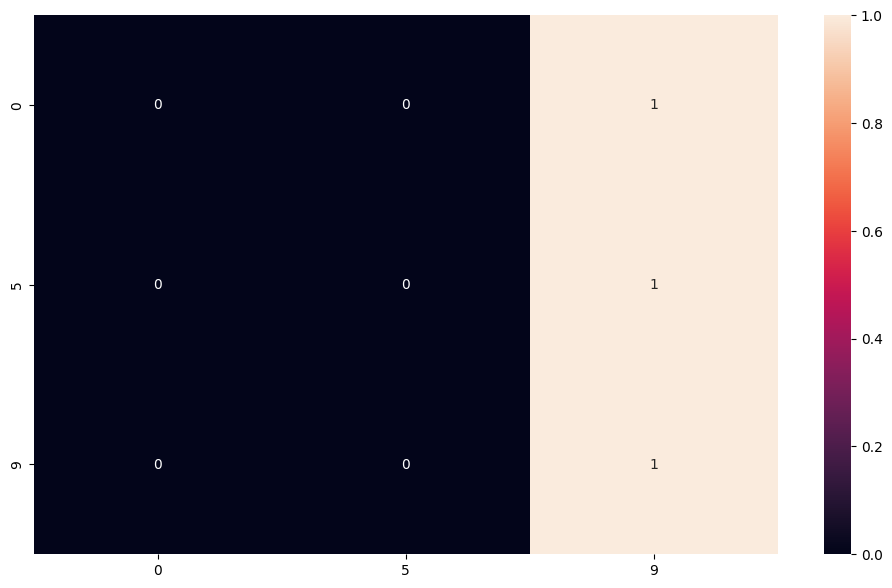

In [ ]:
# Initialize empty lists to store predicted and target labels
pred = []
targ = []

# Iterate through the test_loader_05 using no gradient computation
with torch.no_grad():
    for inputs, targets in test_loader_059:
        # Move inputs and targets to the chosen device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Perform forward pass to get model predictions
        output = model_059(inputs)

        # Convert output into predicted class labels
        prediticted = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()

        # Extend the pred and targ lists with the new predicted and target labels
        pred.extend(prediticted)
        targ.extend(targets.data.cpu().numpy())

# Define class labels
classes = ("0", "5", "9")

# Calculate the confusion matrix
cf_matrix = confusion_matrix(targ, pred)

# Normalize the confusion matrix
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis = 1)[:, None],
                     index = [i for i in classes],
                     columns = [i for i in classes])

# Set up the visualization
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot=True)

# Print the classification report
print(classification_report(targ, pred, target_names = classes))

<p align="justify"> The generale performance is bad. It seems that adding a new class and training just on that data made the model forget the previous notions. This is called <i>catastrophic forgetting</i> and it is one the issues the the field of continual learning is trying to solve.
One possible naive solution could be to retrain the whole model on the complete dataset of our three digits.

In [ ]:
# Specify the layer index until which you want to freeze
freeze_until_layer = 5  # Assuming the Flatten layer is at index 9 in model_059

# Loop through the layers and freeze until the specified layer
for i, (name, param) in enumerate(model_059.named_parameters()):
    if i <= freeze_until_layer:
        param.requires_grad = True
    else:
        break  # Stop freezing after the specified layer

In [ ]:
use_cuda = False
save_model = True

epochs = 3
lr = 1e-2

device = torch.device("cuda" if use_cuda else "cpu")

# Create an optimizer with trainable parameters
optimizer = torch.optim.SGD(model_059.parameters(), lr = lr, momentum = 0.9)

In [ ]:
train_loss059 = []
test_loss059 = []

for epoch in (range(1, epochs + 1)):
    train_loss_ep = train(model_059, device, train_loader_059, optimizer, epoch)
    test_loss_ep = test(model_059, device, test_loader_059)

    train_loss059.append(train_loss_ep)
    test_loss059.append(test_loss_ep)


100%|██████████| 271/271 [00:20<00:00, 13.53batch/s, loss=0.462]



Test set: Average loss: 0.0625, Accuracy: 2824/2881 (98.02%)




100%|██████████| 271/271 [00:20<00:00, 13.53batch/s, loss=0.106]



Test set: Average loss: 0.0393, Accuracy: 2854/2881 (99.06%)




100%|██████████| 271/271 [00:19<00:00, 14.10batch/s, loss=0.0689]



Test set: Average loss: 0.0261, Accuracy: 2856/2881 (99.13%)



In [ ]:
# Compare the weights of the first convolutional layer in both networks
original_weights = model_05.network[5].weight.data
transferred_weights = model_059.network[5].weight.data


weights_equal = torch.allclose(original_weights, transferred_weights)

if weights_equal:
    print("Weight transfer successful!")
else:
    print("Weight transfer not successful.")

Weight transfer not successful.


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           5       0.99      1.00      0.99       892
           9       1.00      0.98      0.99      1009

    accuracy                           0.99      2881
   macro avg       0.99      0.99      0.99      2881
weighted avg       0.99      0.99      0.99      2881



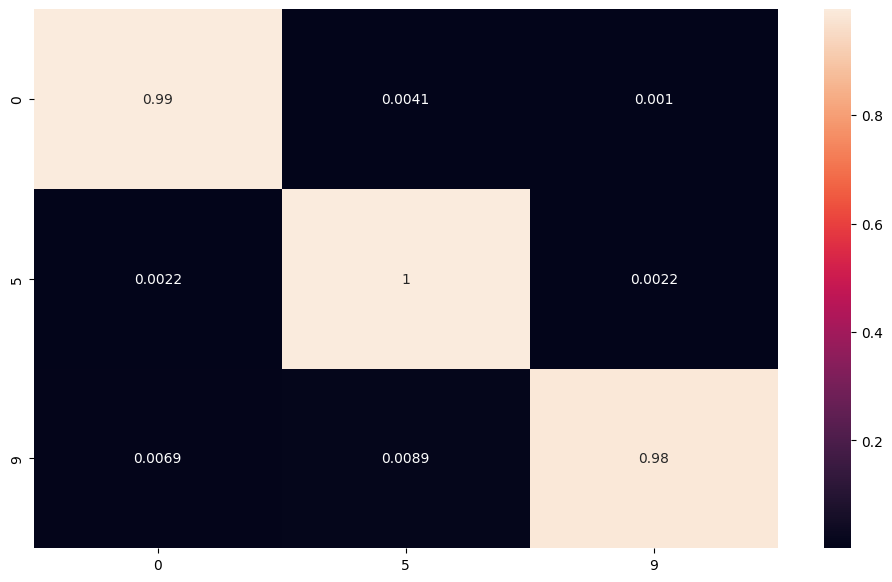

In [ ]:
# Initialize empty lists to store predicted and target labels
pred = []
targ = []

# Iterate through the test_loader_05 using no gradient computation
with torch.no_grad():
    for inputs, targets in test_loader_059:
        # Move inputs and targets to the chosen device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Perform forward pass to get model predictions
        output = model_059(inputs)

        # Convert output into predicted class labels
        prediticted = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()

        # Extend the pred and targ lists with the new predicted and target labels
        pred.extend(prediticted)
        targ.extend(targets.data.cpu().numpy())

# Define class labels
classes = ("0", "5", "9")

# Calculate the confusion matrix
cf_matrix = confusion_matrix(targ, pred)

# Normalize the confusion matrix
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis = 1)[:, None],
                     index = [i for i in classes],
                     columns = [i for i in classes])

# Set up the visualization
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot=True)

# Print the classification report
print(classification_report(targ, pred, target_names = classes))

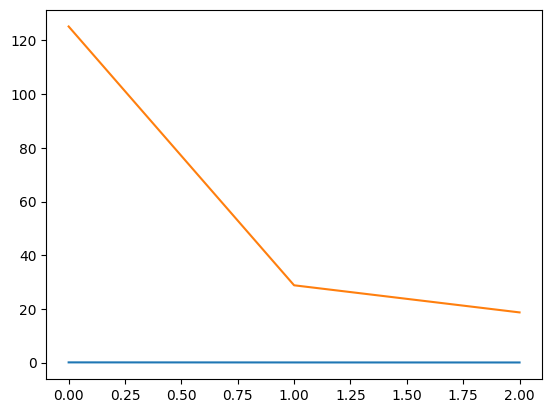

In [ ]:
plt.plot(test_loss059)
plt.plot(train_loss059)

<p align="justify"> The results appear promising at first glance, which might lead us to believe that the problem has been solved. However, this approach becomes quite unwieldy when considering the need to change the architecture every time a new class is introduced. While this manner of thinking might hold for the simple example dataset we've used, a broader perspective reveals several underlying issues.

<p align="justify"> For instance, consider a scenario where an autonomous car is being trained to drive. The datasets used for training the object recognition component of the algorithm need to be extensive. This is essential to ensure the car avoids collisions with pedestrians and minimizes damage to its surroundings. Complications arise when there are changes in traffic laws or new road signs are introduced. In such cases, a conventional machine learning algorithm would necessitate retraining from scratch. Unlike the quick reconfiguration we saw in our modest example, this process wouldn't take just a few minutes but considerably longer.

We can delve even deeper into the analysis of the problem, demonstrating its persistence across all ten classes of the MNIST dataset. To accomplish this, we introduce a new library called [Avalanche](https://avalanche.continualai.org/), which simplifies our life.

In [ ]:
%%capture
!pip install avalanche-lib

After installing the library We update our model in order to make it suitable for the functions of Avalanche. In this case we added a variable to change the number of classes whenever the model is called.

In [ ]:
# Define a neural network architecture named 'BigRoosterNET'
class MoodyRoosterNET(torch.nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(1, 4, kernel_size = 6, stride = 1, padding = 1),
            torch.nn.Dropout2d(0.05),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 8, kernel_size = 6, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, kernel_size = 2, stride = 2, padding = 1),
            torch.nn.Dropout2d(0.2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),

            torch.nn.Linear(576, 86),
            torch.nn.ReLU(),
            torch.nn.Linear(86, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

We import the necessary modules from avalanche.

> <p align="justify"> <b>SplitMNIST</b> takes this dataset and divides it into subsets, or "splits," where each split contains a subset of the original classes.

> <p align="justify"> The <b>InteractiveLogger</b> and <b>TextLogger</b> classes are used to log the training and evaluation results of a continual learning experiment. The <b>InteractiveLogger</b> logs the results to the console, and the <b>TextLogger</b> logs the results to a file. These loggers can be used to track the performance of a continual learning algorithm over time.

> <p align="justify"> <b>EvaluationPlugin</b> takes a list of metrics as input, and it evaluates the model on these metrics after each experience. This allows us to track how the performance of a continual learning algorithm changes over time.

> <p align="justify"> The <b>forgetting_metrics</b> measure how much the model forgets about previously learned knowledge. The <b>accuracy_metrics</b> measure the accuracy of the model on the current experience. The <b>loss_metrics</b> measure the loss of the model on the current experience. The <b>StreamConfusionMatrix</b> metric computes the confusion matrix of the model on the current experience.

> <p align="justify"> The <b>Naive</b> strategy trains a new model for each experience. This is the simplest and most straightforward approach, but it is also the least effective. The reason is that each new model will only be trained on the current experience, and it will not have any knowledge of the previous experiences. This can lead to catastrophic forgetting, where the model forgets the knowledge that it has learned from previous experiences.

In [ ]:
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,\
    loss_metrics, StreamConfusionMatrix

### Naive Approach
---

<p align="justify"> The <b>Naive</b> strategy trains a new model for each experience. This is the simplest and most straightforward approach, but it is also the least effective. The reason is that each new model will only be trained on the current experience, and it will not have any knowledge of the previous experiences. This can lead to catastrophic forgetting, where the model forgets the knowledge that it has learned from previous experiences.

In [ ]:
from avalanche.training.supervised import Naive

In [ ]:
%%capture
# Create a SplitMNIST scenario with 10 experiences (classes)
scenario = SplitMNIST(n_experiences = 10, seed = random_seed)

# Create a SimpleMLP model with the number of classes in the scenario
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# Define evaluation loggers for different outputs]
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file
interactive_logger = InteractiveLogger()  # Print to stdout (interactive)

# Define an EvaluationPlugin that manages metric computation and output
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


# Create a Naive continual learning strategy instance
cl_strategy = Naive(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    evaluator = eval_plugin
)

In [ ]:
print(model)

MoodyRoosterNET(
  (network): Sequential(
    (0): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.05, inplace=False)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (6): Dropout2d(p=0.2, inplace=False)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=576, out_features=86, bias=True)
    (11): ReLU()
    (12): Linear(in_features=86, out_features=10, bias=True)
  )
)


In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [2]
100%|██████████| 60/60 [00:10<00:00,  5.83it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:01<00:00,  8.36it/s]
Start of experience:  1
Current Classes:  [6]
100%|██████████| 60/60 [00:07<00:00,  8.07it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 12.54it/s]
Start of experience:  2
Current Classes:  [1]
100%|██████████| 68/68 [00:06<00:00, 10.77it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 19.49it/s]
Start of experience:  3
Current Classes:  [8]
100%|██████████| 59/59 [00:03<00:00, 15.72it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:01<00:00, 10.37it/s]
Start of experience:  4
Current Classes:  [4]
100%|██████████| 59/59 [00:04<00:00, 13.15it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████

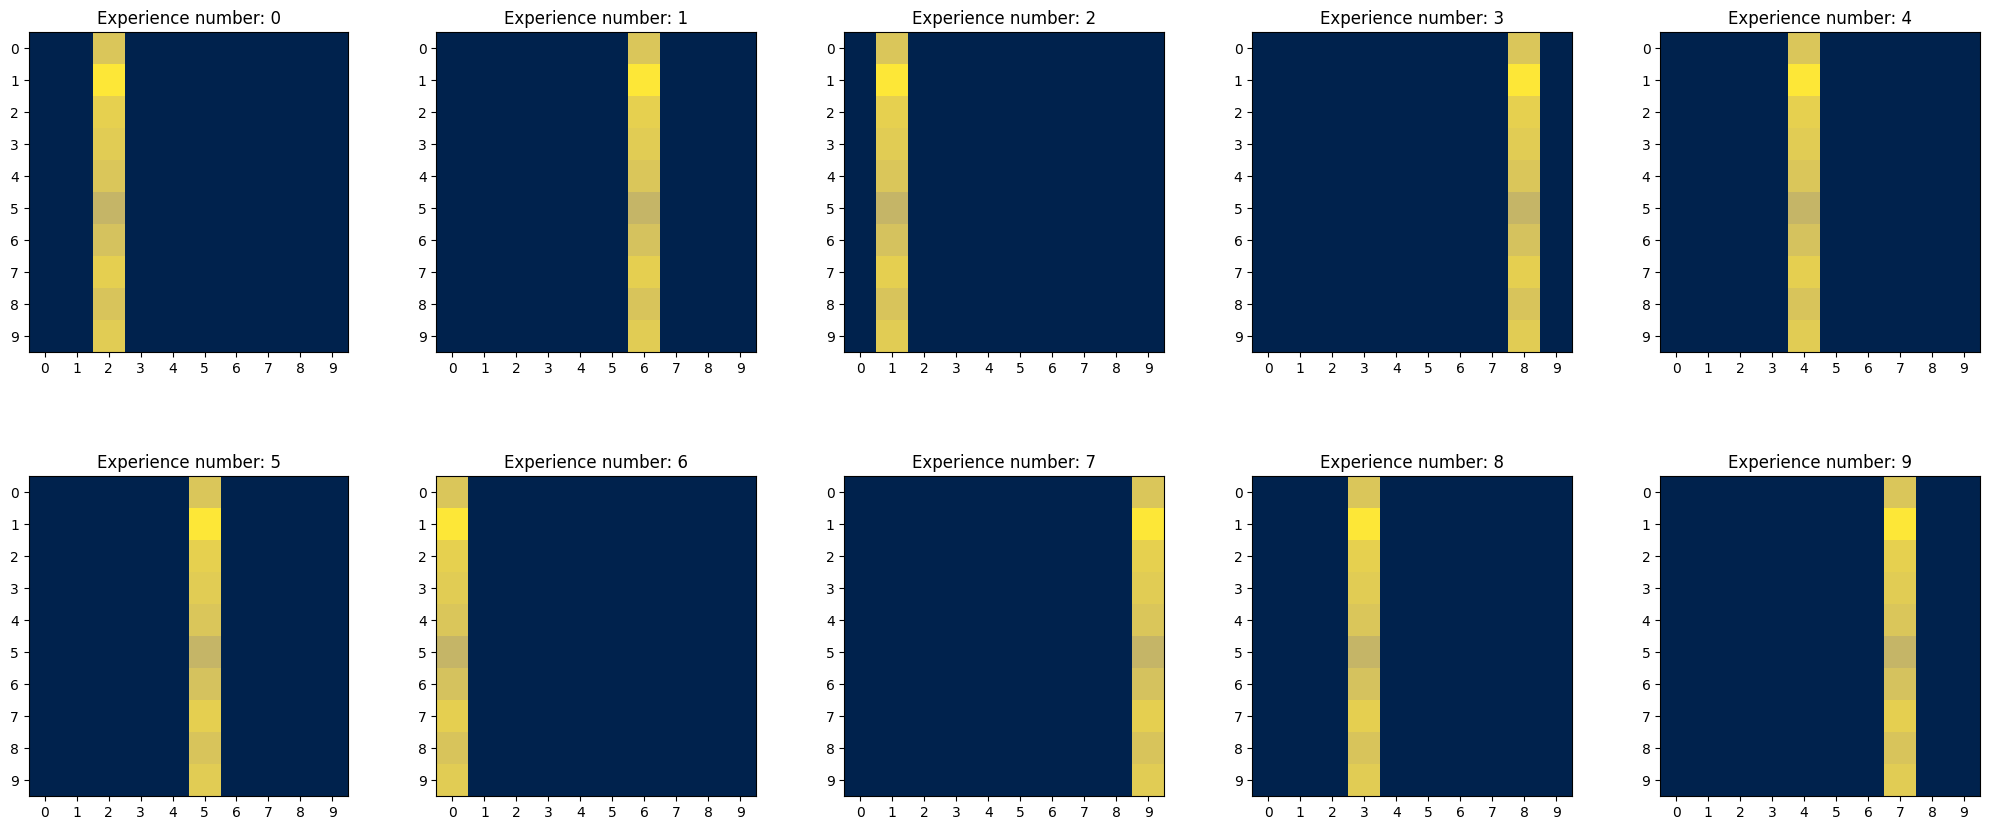

In [ ]:
NC_NA_cf_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2, 5, i+1)
  NC_NA_cf_matrix.append(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

fig.tight_layout(h_pad = -50, w_pad = 5)
plt.savefig(f'{images_dir}/NC_NA_CF.pdf', format = "pdf")
plt.show()

In [ ]:
# The ExperienceForgetting metric, describing the accuracy loss
# detected for a certain experience.
# This plugin metric, computed separately for each experience,
# is the difference between the accuracy result obtained after
# first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.



# The StreamForgetting metric, describing the average evaluation accuracy loss
# detected over all experiences observed during training.
# This plugin metric, computed over all observed experiences during training,
# is the average over the difference between the accuracy result obtained
# after first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.

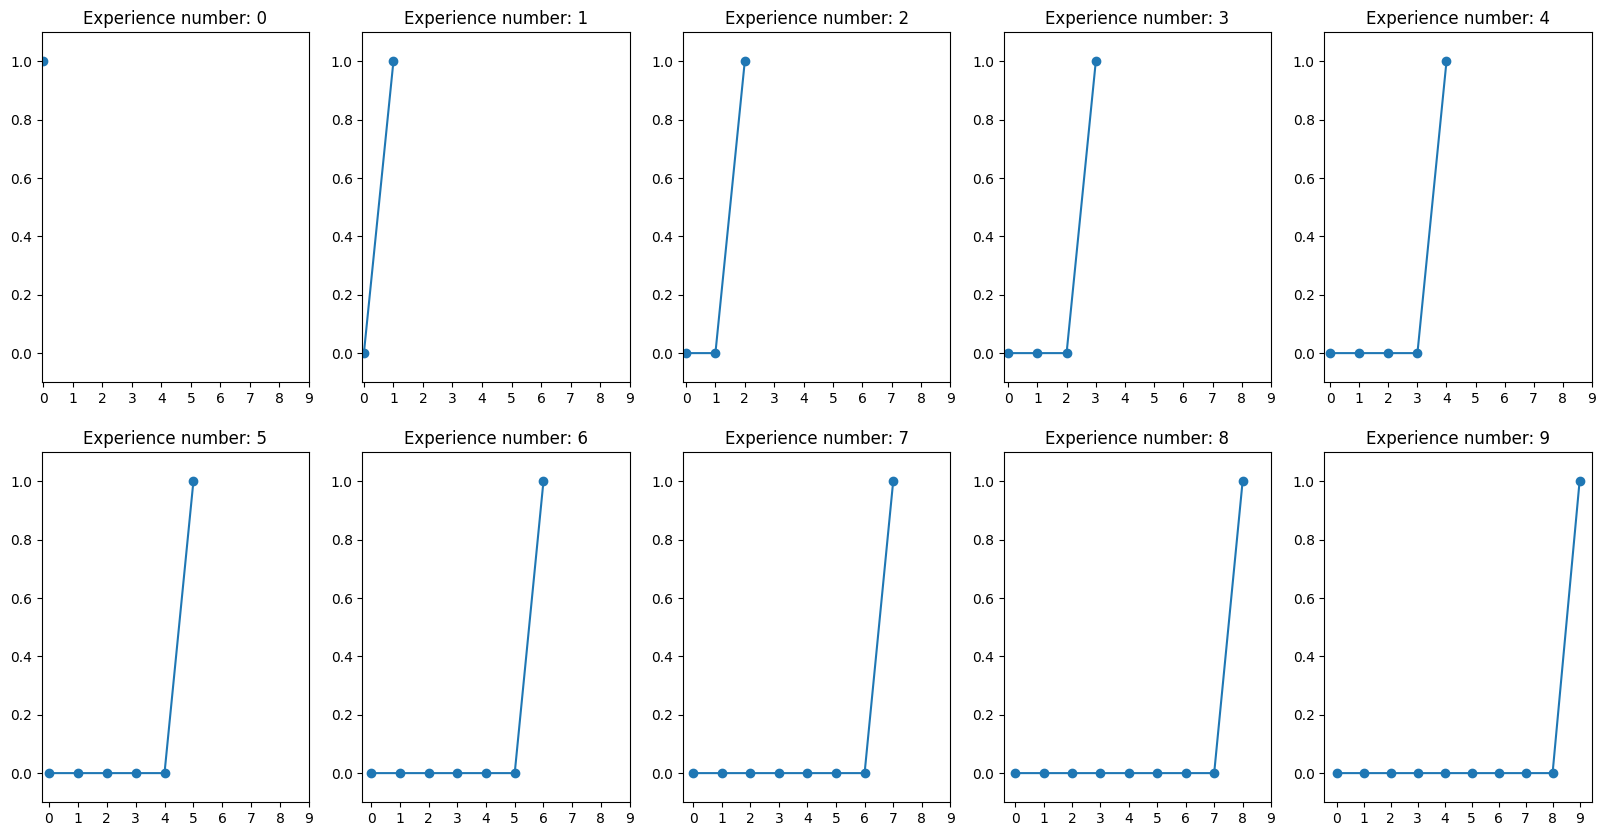

In [ ]:
keys = list(results[0].keys())
acc_keys = [n for n in keys if n[:-1] == 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00']

NC_NA_acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NC_NA_acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_NA_acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')
plt.savefig(f'{images_dir}/NC_NA_ACC.pdf', format = "pdf")
plt.show()

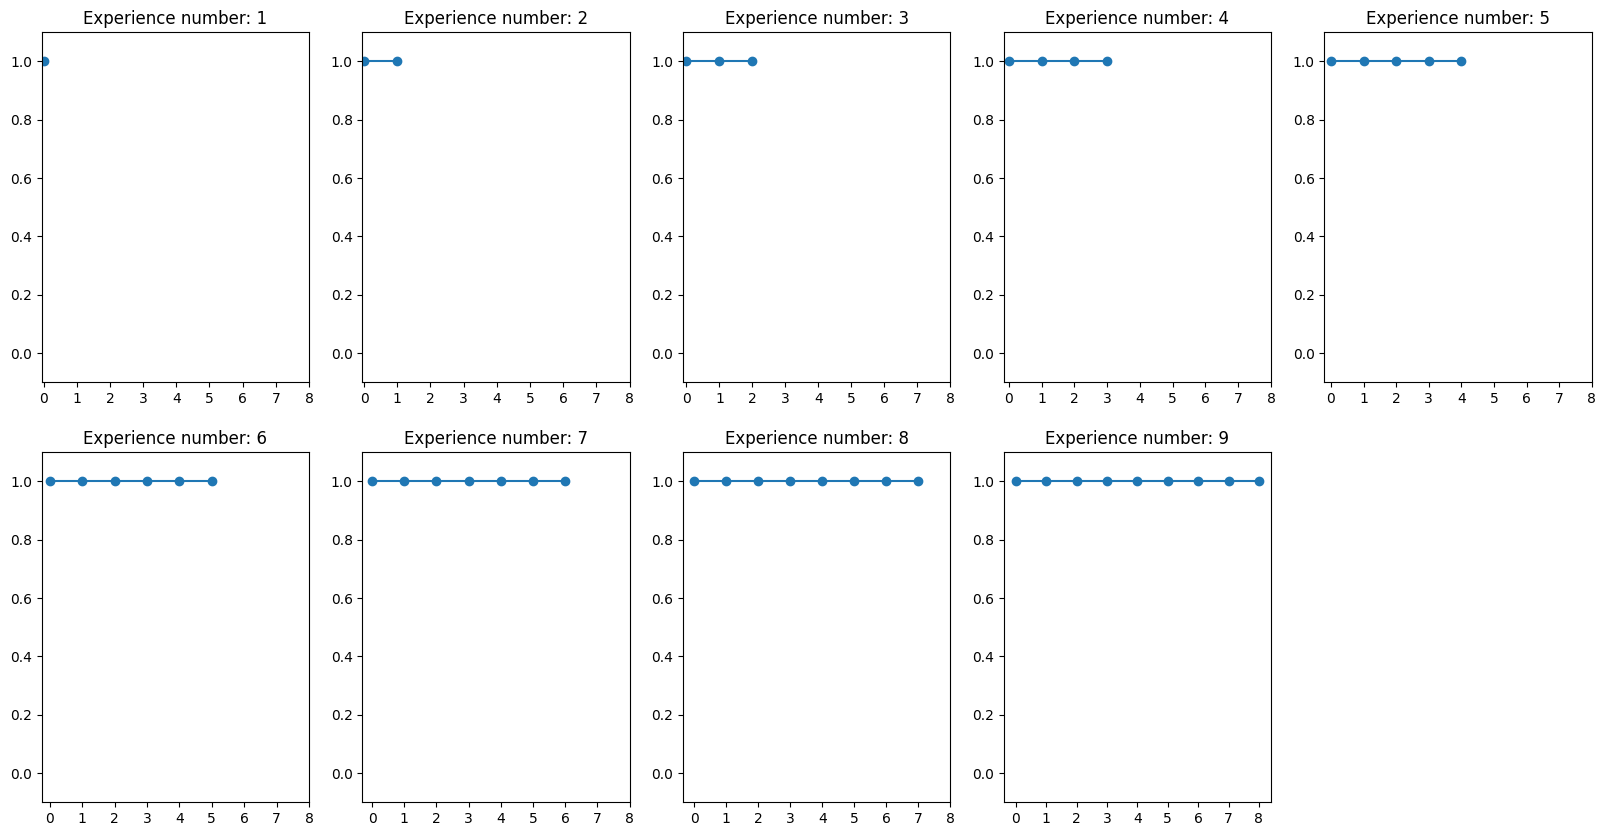

In [ ]:
keys = list(results[9].keys())
forg_keys = [n for n in keys if n[:-1] == 'ExperienceForgetting/eval_phase/test_stream/Task000/Exp00']

NC_NA_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NC_NA_FORG_matrix.append(forg)
    i = i + 1

NC_NA_FORG_matrix = NC_NA_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_NA_FORG_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,9)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NC_NA_FORG. pdf", format = "pdf")
plt.show()

### Cumulative Approach
---

<p align="justify"> The <b>Cumulative</b> approach to continual learning is a technique where a single model is trained on all of the experiences, one after the other. This is in contrast to the naive approach, where a new model is trained for each experience.

In [ ]:
from avalanche.training.supervised import Cumulative

In [ ]:
# Create a SimpleMLP model with the number of classes in the scenario
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# Create a Cumulative continual learning strategy instance
cl_strategy = Cumulative(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 128, train_epochs = 5, eval_mb_size = 100,
    evaluator = eval_plugin
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [2]
100%|██████████| 47/47 [00:06<00:00,  7.58it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 16.84it/s]
Start of experience:  1
Current Classes:  [6]
100%|██████████| 93/93 [00:09<00:00, 10.00it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 18.23it/s]
Start of experience:  2
Current Classes:  [1]
100%|██████████| 146/146 [00:11<00:00, 12.88it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 16.86it/s]
Start of experience:  3
Current Classes:  [8]
100%|██████████| 192/192 [00:17<00:00, 11.16it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 16.08it/s]
Start of experience:  4
Current Classes:  [4]
100%|██████████| 237/237 [00:26<00:00,  8.80it/s]
Training completed
Computing accuracy on the whole test set
100%|████

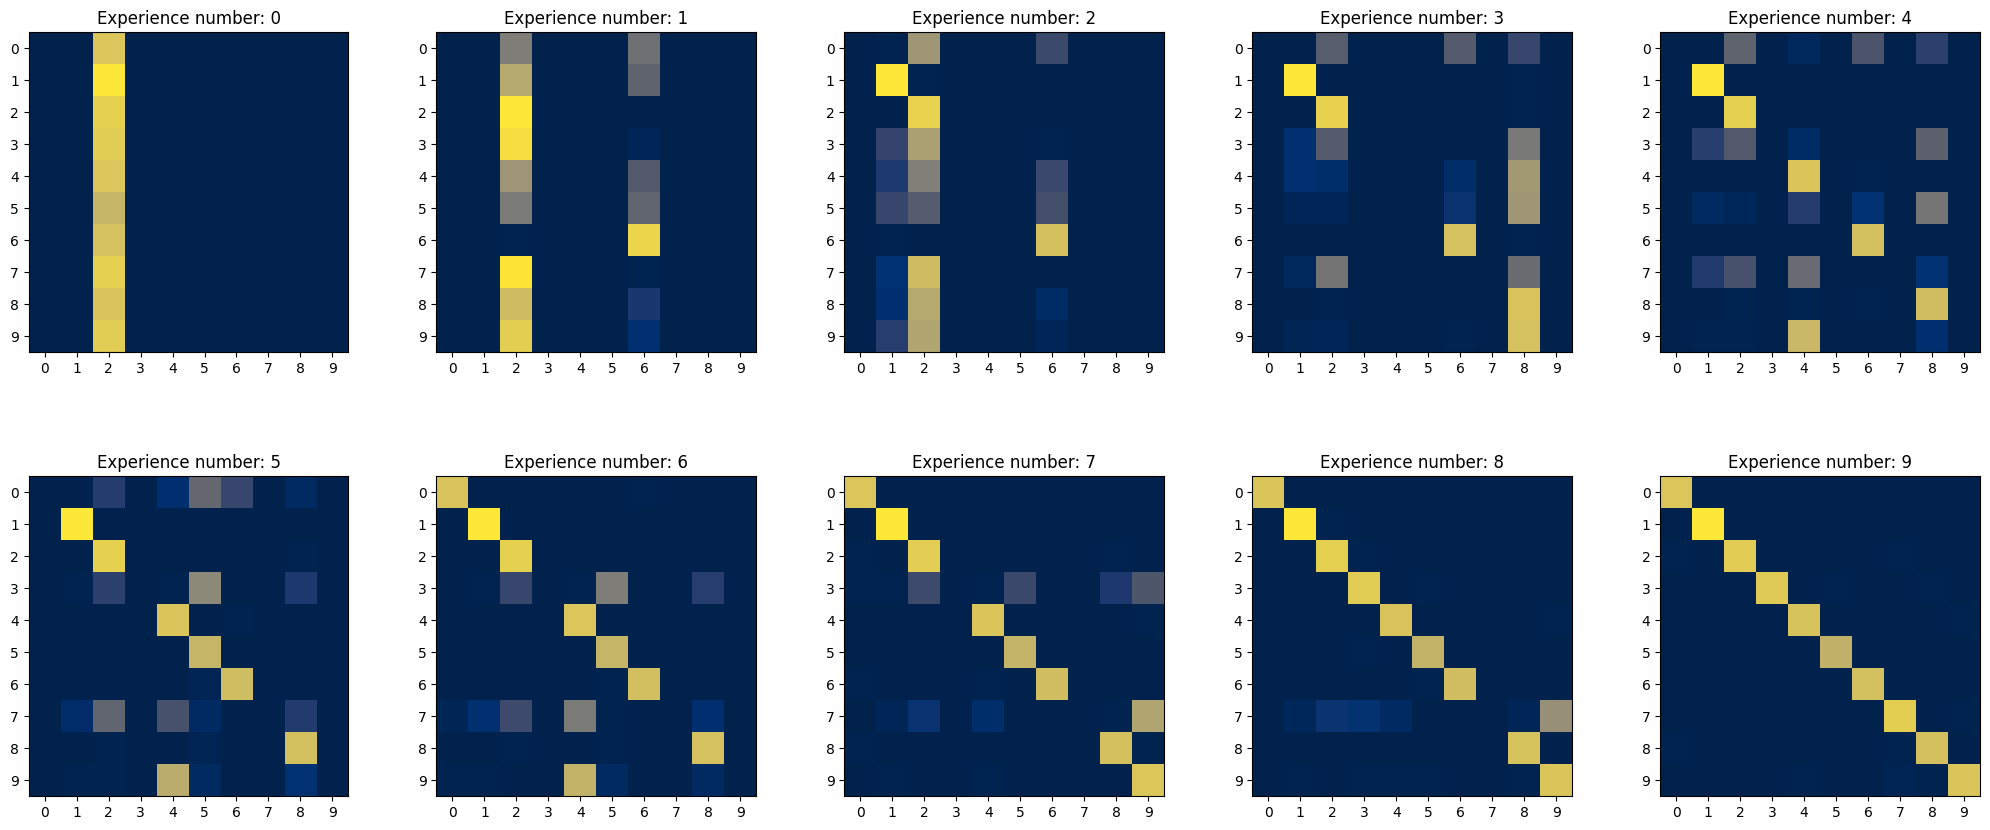

In [ ]:
n_exp = len(results)

NC_CA_cf_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2, 5, i+1)
  NC_CA_cf_matrix.append(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt. savefig("NC_CA_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

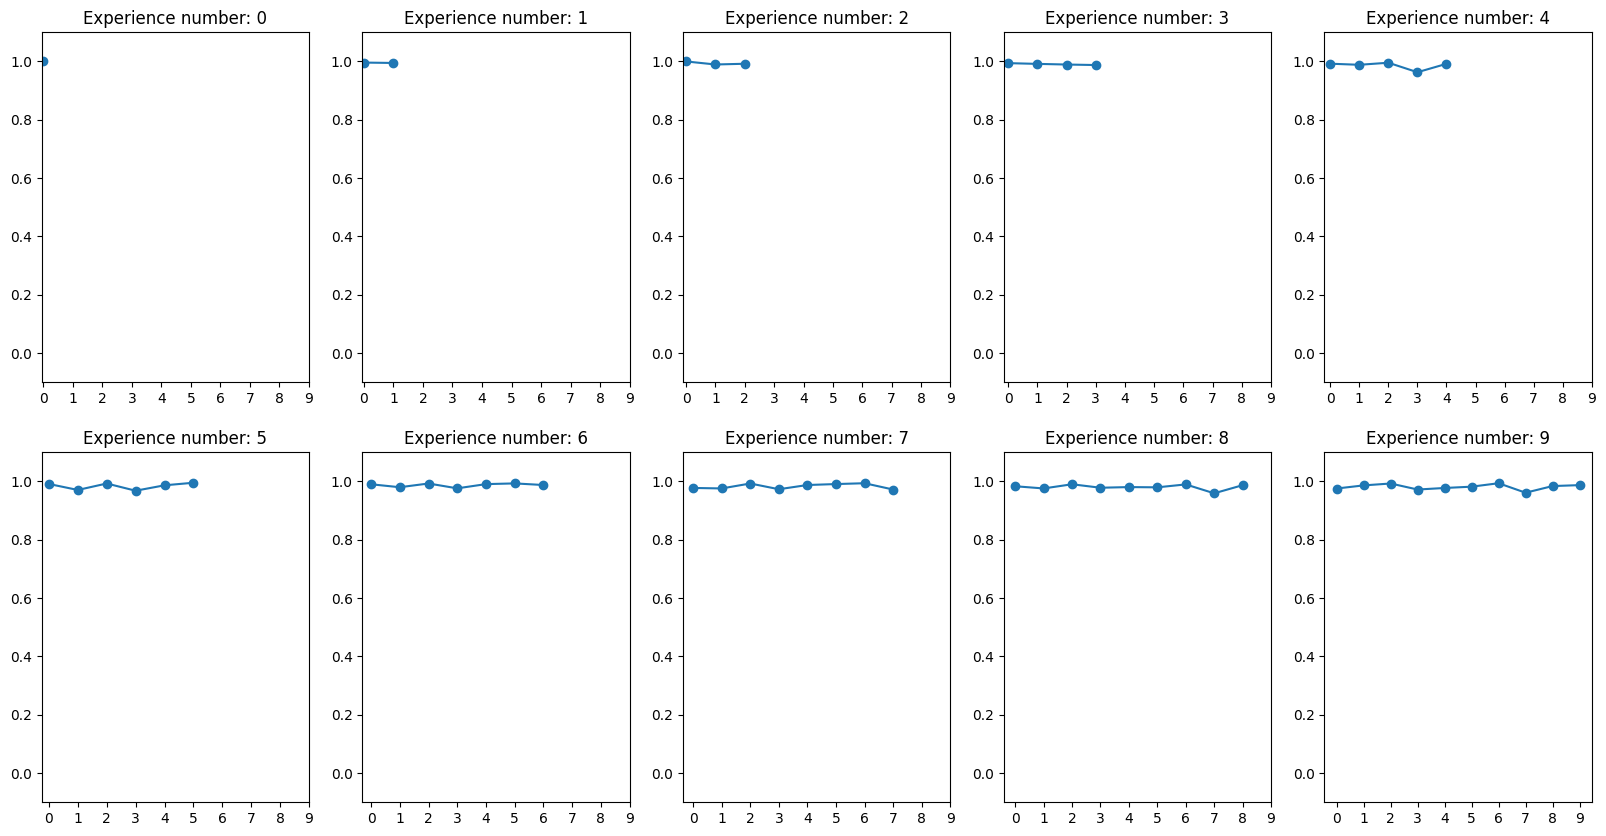

In [ ]:
NC_CA_acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NC_CA_acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_CA_acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')

plt.show()

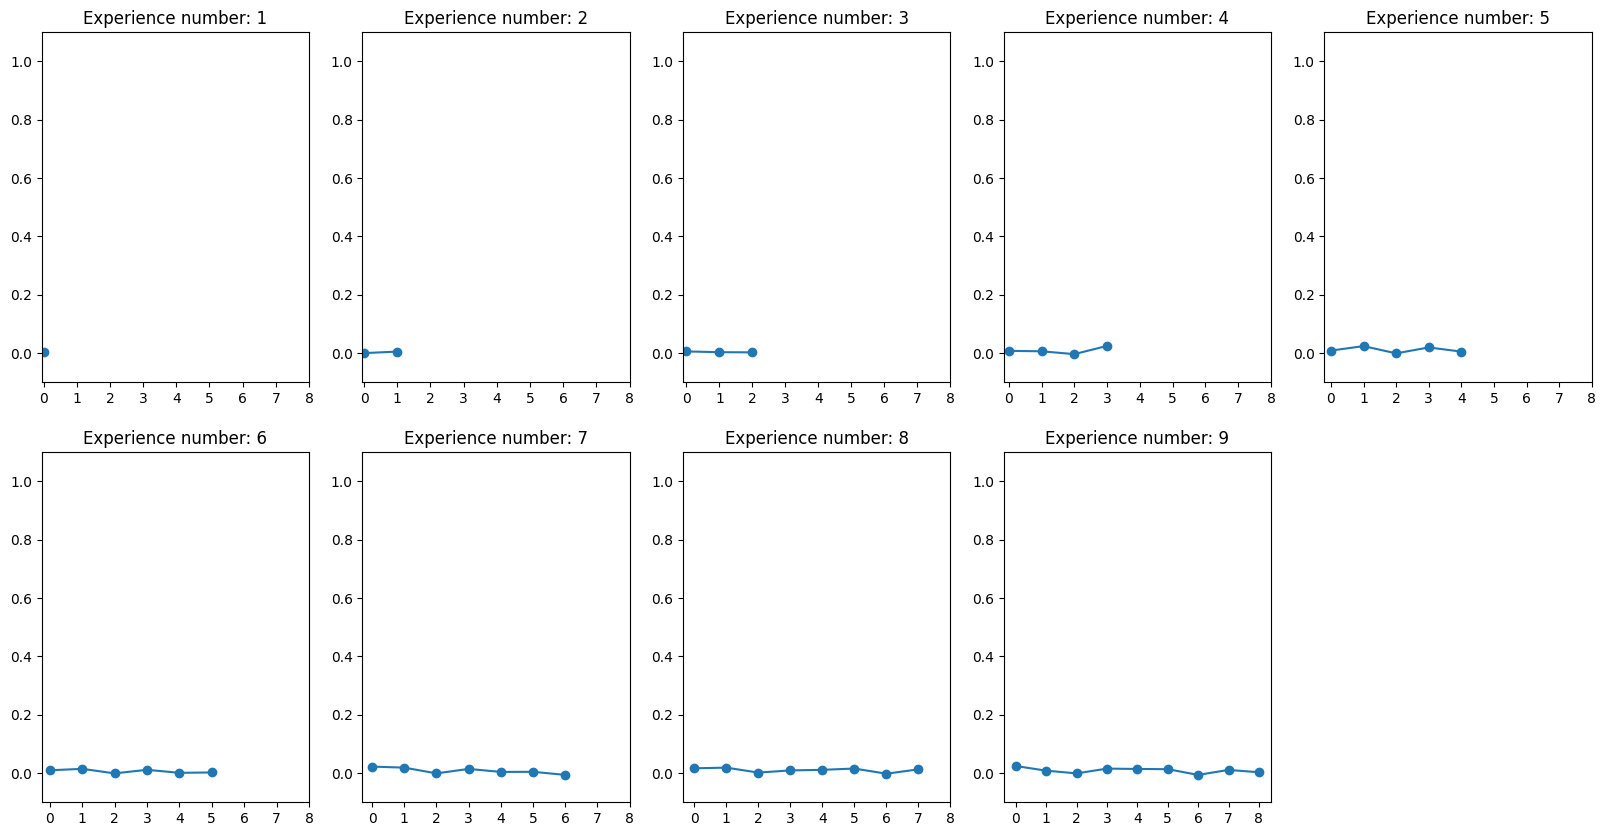

In [ ]:
NC_CA_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NC_CA_FORG_matrix.append(forg)
    i = i + 1

NC_CA_FORG_matrix = NC_CA_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_CA_FORG_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,9)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NC_CA_FORG. pdf", format = "pdf")
plt.show()

<p align="justify"> As mentioned earlier, it might appear that the problem has been resolved due to the notably high accuracy on the test set and minimal occurrence of forgetting. However, this situation presents certain drawbacks. For instance, with larger datasets, incorporating a new class could lead to an impractical increase in the training time for a network that encompasses the entire accumulated dataset. Additionally, the assumption we're making, that the data will always remain accessible, is not valid, especially for more extensive datasets. In such cases, older data often gets discarded or compressed as a cost-saving measure for storage.

<p align="justify"> IDC recently released a <a href="https://www.seagate.com/www-content/our-story/trends/files/Seagate-WP-DataAge2025-March-2017.pdf">white paper</a> in which they put forth the argument  that by the year 2025, the rate of data generation will surge from the current 16 zettabytes per year (that's equivalent to a trillion gigabytes) to a staggering 160 zettabytes. However, it's projected that we will only have the capacity to store a mere 3% to 12% of this colossal amount. To put it plainly, data will need to be processed in real-time, as failing to do so would result in its permanent loss due to storage technology struggling to keep pace with the pace of data production.

<p align="justify"> So let's see some strategies that take into account the possibility that the data might not be available once used.

### Replay Approach
---

<p align = 'justify'> The <b>Replay</b> approach is a continual learning method that stores data from previous tasks in a memory buffer. This data can then be replayed to the model during training on new tasks, helping the model to avoid forgetting what it has learned.

In [ ]:
from avalanche.training.plugins import ReplayPlugin
from avalanche.training.templates import SupervisedTemplate

> <p align="justify"> The <b>ReplayPlugin</b> handles an external memory that is filled with randomly selected patterns. It also implements two callbacks: <i>before_training_exp</i> and <i>after_training_exp</i>.
The <i>before_training_exp</i> callback is used to create a dataloader that generates mini-batches of examples from both the training data and the external memory. The examples in the mini-batch are balanced, meaning that there is an equal number of examples for each experience.
The <i>after_training_exp</i> callback is used to update the external memory with the new experiences that were learned during training.

> <p align="justify"> The <b>SupervisedTemplate</b> class is a parent class for all supervised task-based continual learning strategies. It provides a basic training loop and a callback system that allows you to run code at each experience of the training loop. Plugins can be used to extend the training loop with additional behavior, such as a memory buffer for replay.

In [ ]:
model = MoodyRoosterNET(num_classes = scenario.n_classes)


replay = ReplayPlugin(mem_size = 300)

# choose some metrics and evaluation method
interactive_logger = InteractiveLogger()
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


cl_strategy =SupervisedTemplate(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 50, train_epochs = 5, eval_mb_size = 100,
    plugins=[replay],
    evaluator = eval_plugin,
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience ", experience.current_experience)
    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience  0
-- >> Start of training phase << --
100%|██████████| 120/120 [00:05<00:00, 20.62it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1439
	Loss_MB/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9846
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 120/120 [00:06<00:00, 17.78it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Loss_MB/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 120/120 [00:04<00:00, 25.28it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Loss_MB/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 120/120 [00:04<00:00, 24.40it/s]
Epoch 3 ended.
	Los

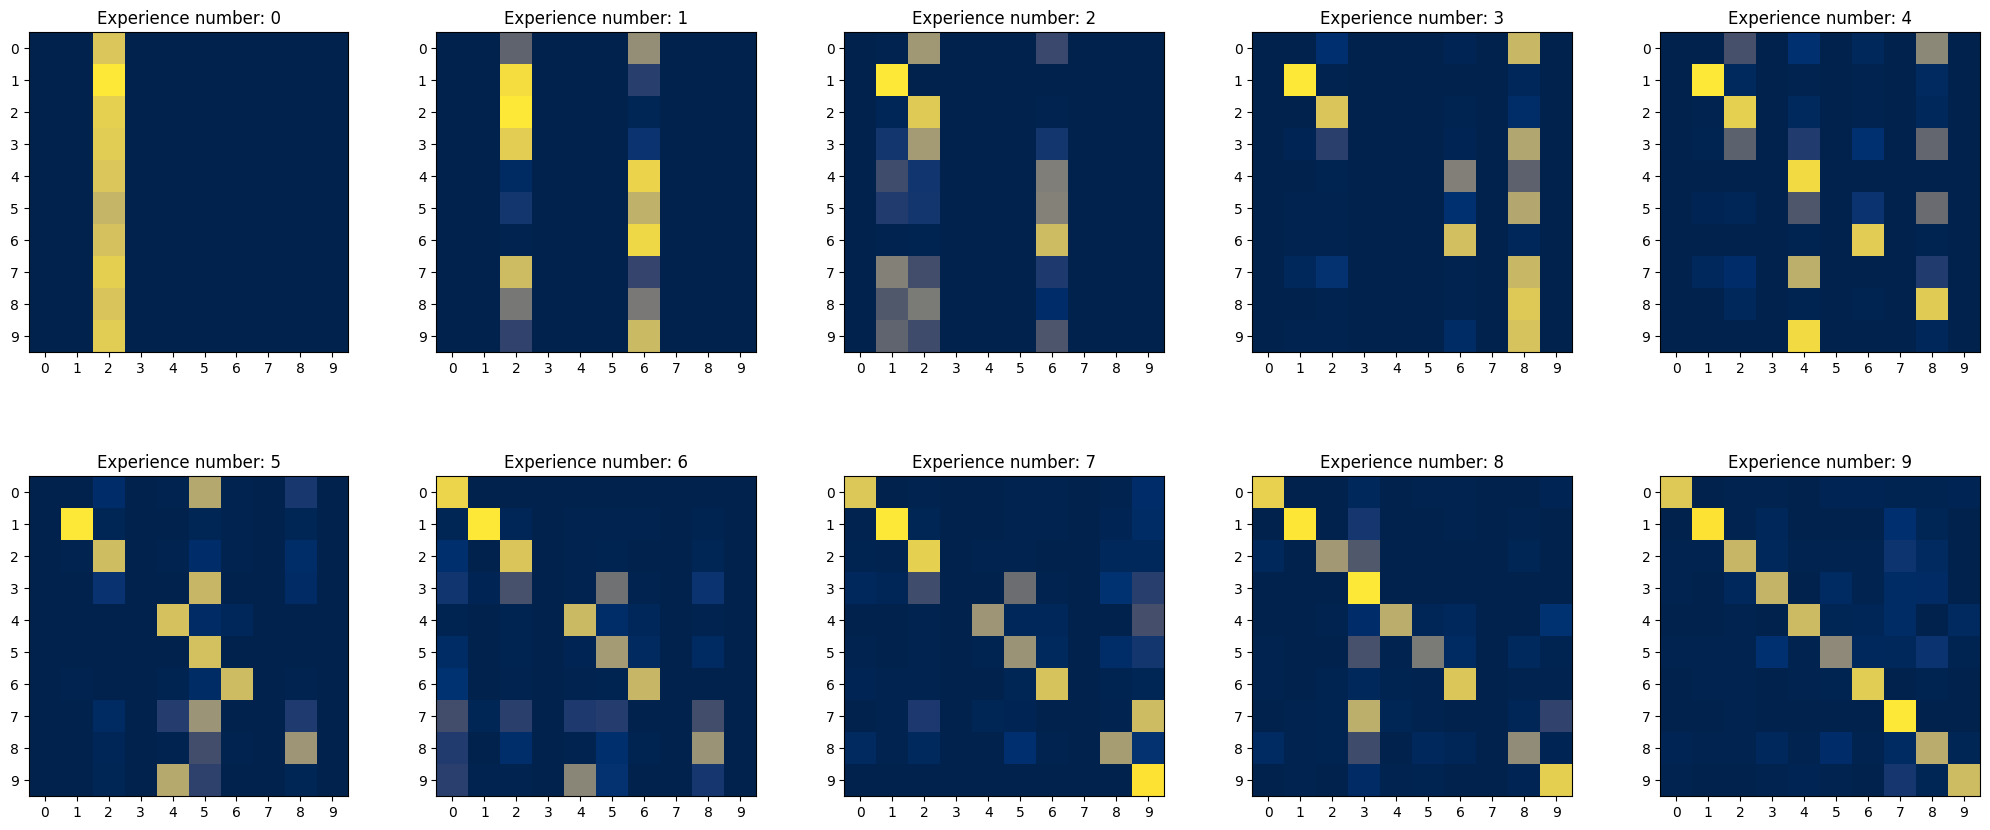

In [ ]:
n_exp = len(results)

NC_RA_cf_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2, 5, i+1)
  NC_RA_cf_matrix.append(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt. savefig("NC_RA_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

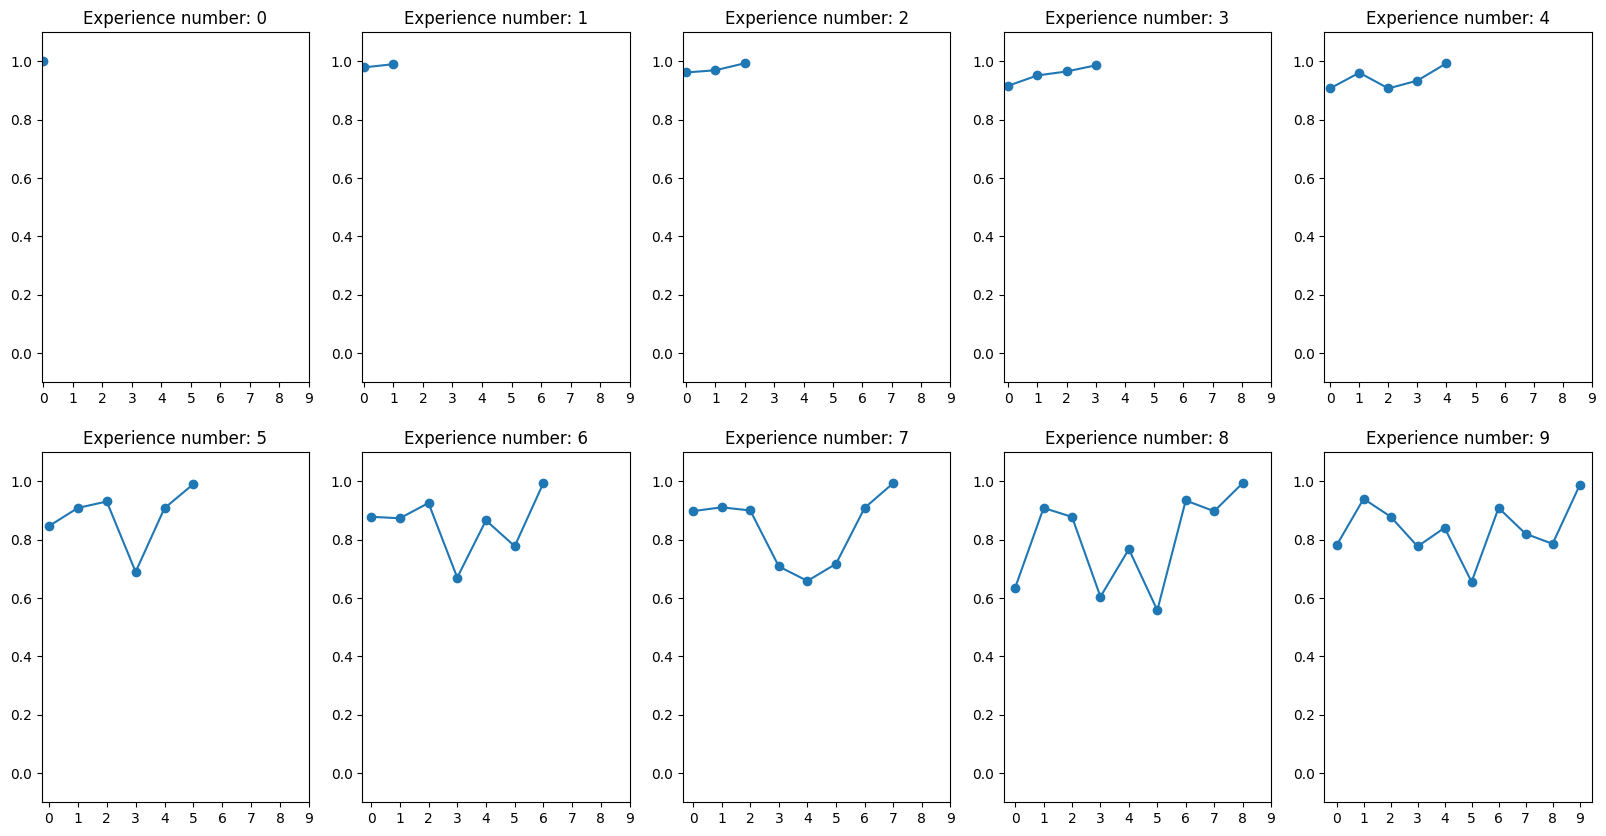

In [ ]:
NC_RA_acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NC_RA_acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_RA_acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')
plt. savefig("NC_RA_ACC. pdf", format = "pdf")
plt.show()

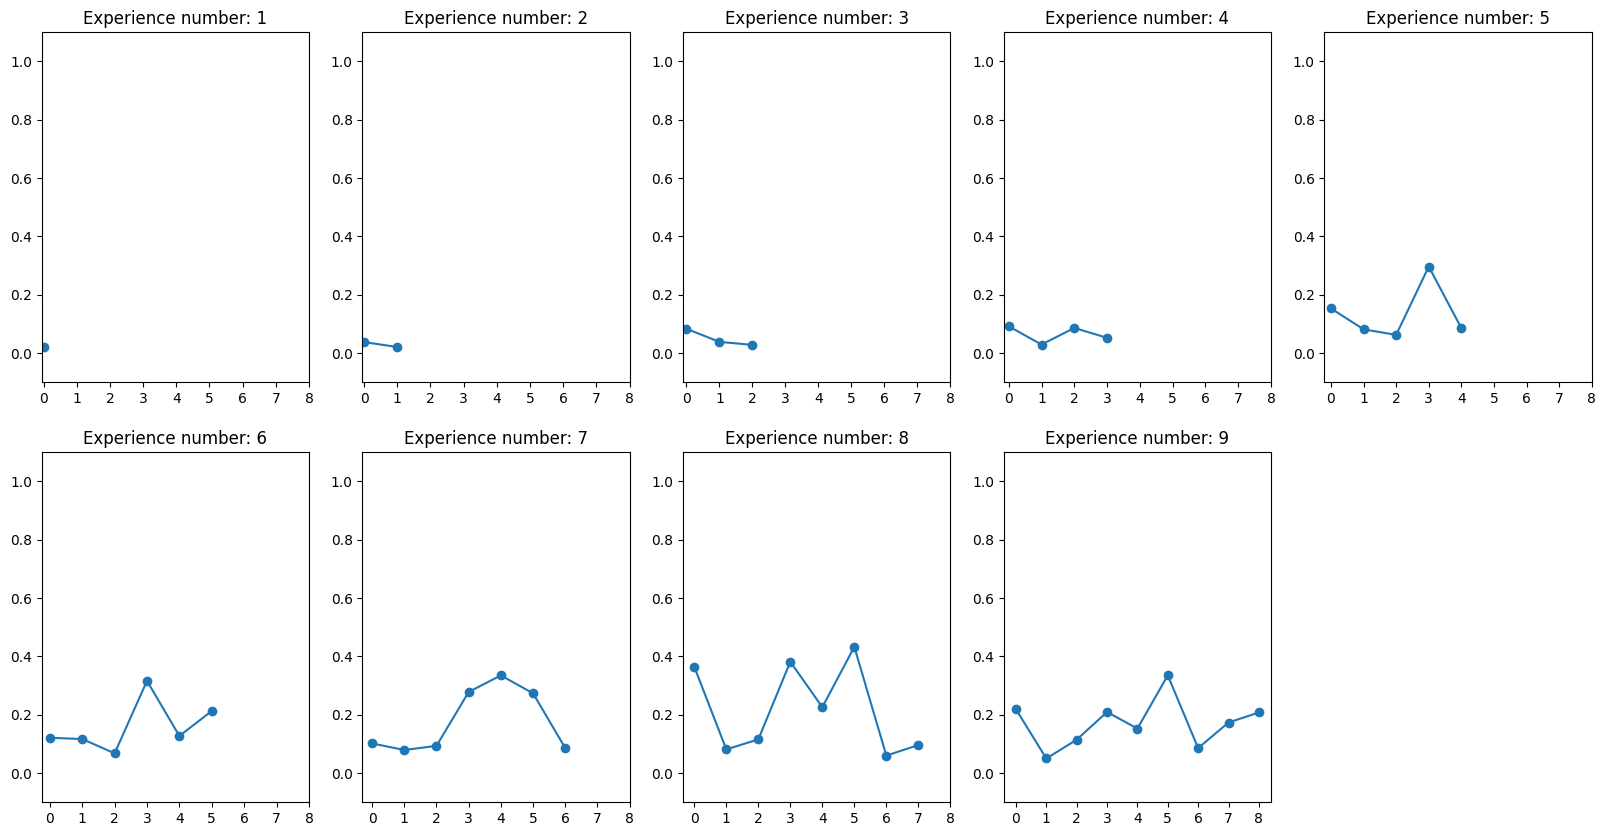

In [ ]:
NC_RA_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NC_RA_FORG_matrix.append(forg)
    i = i + 1

NC_RA_FORG_matrix = NC_RA_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_RA_FORG_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,9)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NC_RA_FORG. pdf", format = "pdf")
plt.show()

In [ ]:
exp_forgetting_keys = [n for n in keys if n[:-1] == 'ExperienceForgetting/eval_phase/test_stream/Task000/Exp00']

i = 0
for r in results:
    print("Experience ", i)
    print("\n")

    forg = [r[key] for key in acc_keys]
    print("ExperienceForgetting:", forg)
    print("StreamForgetting:", r['StreamForgetting/eval_phase/test_stream'])
    print("\n")
    print("-----------------------------------------------------------")
    print("\n")
    i += 1

Experience  0


ExperienceForgetting: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
StreamForgetting: 0.0


-----------------------------------------------------------


Experience  1


ExperienceForgetting: [0.9796511627906976, 0.9906054279749478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
StreamForgetting: 0.02034883720930236


-----------------------------------------------------------


Experience  2


ExperienceForgetting: [0.9622093023255814, 0.9697286012526096, 0.9938325991189427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
StreamForgetting: 0.029333762198378355


-----------------------------------------------------------


Experience  3


ExperienceForgetting: [0.9166666666666666, 0.9519832985386222, 0.9656387665198238, 0.9866529774127311, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
StreamForgetting: 0.05004976512292595


-----------------------------------------------------------


Experience  4


ExperienceForgetting: [0.9079457364341085, 0.9613778705636743, 0.9074889867841409, 0.934291581108829

<p align="justify"> Increasing the value of <i>mem_size</i> in the ReplayPlugin improves the performance of the model. This is because a larger memory buffer allows the model to store more data from previous tasks, which helps the model to learn from previous tasks and avoid forgetting what it has learned. When the value of mem_size is large enough, the approach becomes cumulative.

### Elastic Weights Consolidation Approach
---

<p align = 'justify'> <b>EWC</b> works by adding a penalty to the loss function that encourages the weights of the model to stay close to their values on previous tasks. The penalty is weighted by the importance of each weight, which is determined by how much it contributes to the performance of the model on the previous task.

In [ ]:
from avalanche.training import EWC

> <p align = 'justify'> The Elastic Weight Consolidation (EWC) plugin determines the significance of individual weights once training on the current data is completed. Throughout training on each mini-batch, the loss is modified with a penalty that maintains the current weight values in proximity to their values during prior experiences, relative to their significance in those experiences. The computation of importances involves an extra iteration on the training dataset.

In [ ]:
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# choose some metrics and evaluation method
interactive_logger = InteractiveLogger()
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


cl_strategy = EWC(
    model,
    torch.optim.SGD(model.parameters(), lr = 2e-4),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    ewc_lambda = 5e-3,
    evaluator = eval_plugin,
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience ", experience.current_experience)
    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience  0
-- >> Start of training phase << --
100%|██████████| 60/60 [00:04<00:00, 14.95it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2224
	Loss_MB/train_phase/train_stream/Task000 = 2.2067
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4204
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6379
100%|██████████| 60/60 [00:03<00:00, 15.30it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.1855
	Loss_MB/train_phase/train_stream/Task000 = 2.1634
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8124
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8966
100%|██████████| 60/60 [00:05<00:00, 10.25it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.1468
	Loss_MB/train_phase/train_stream/Task000 = 2.1278
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9589
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9828
100%|██████████| 60/60 [00:04<00:00, 13.23it/s]
Epoch 3 ended.
	Loss_Epoch/

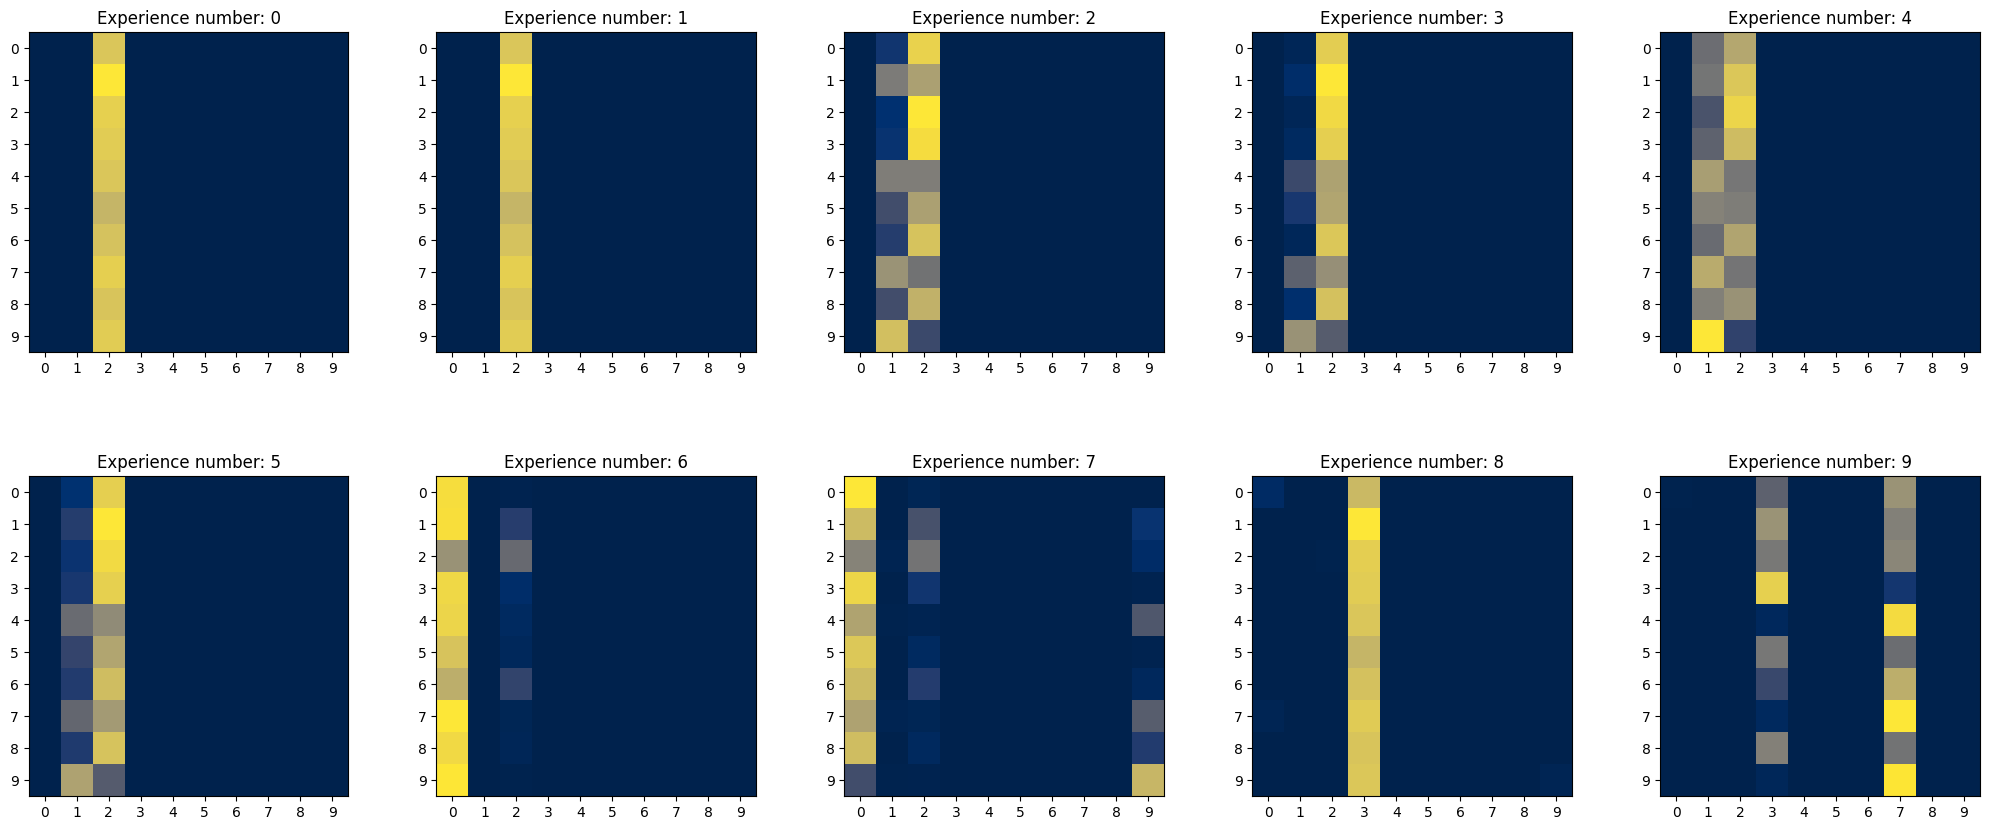

In [ ]:
NC_EWC_cf_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2, 5, i+1)
  NC_EWC_cf_matrix.append(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt. savefig("NC_EWC_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

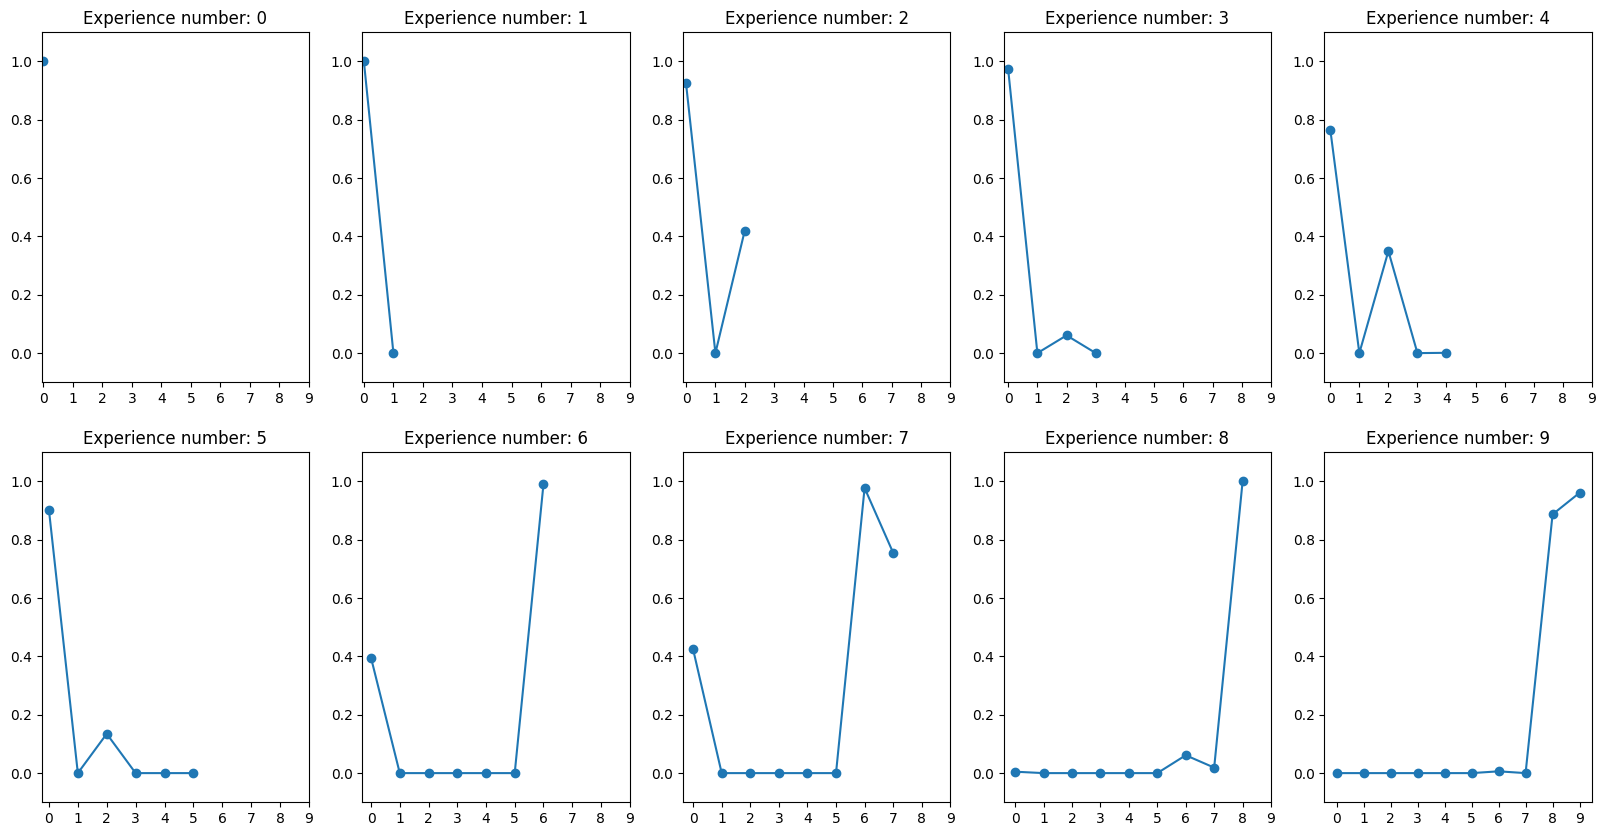

In [ ]:
NC_EWC_acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NC_EWC_acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_EWC_acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')

plt. savefig("NC_EWC_ACC. pdf", format = "pdf")
plt.show()

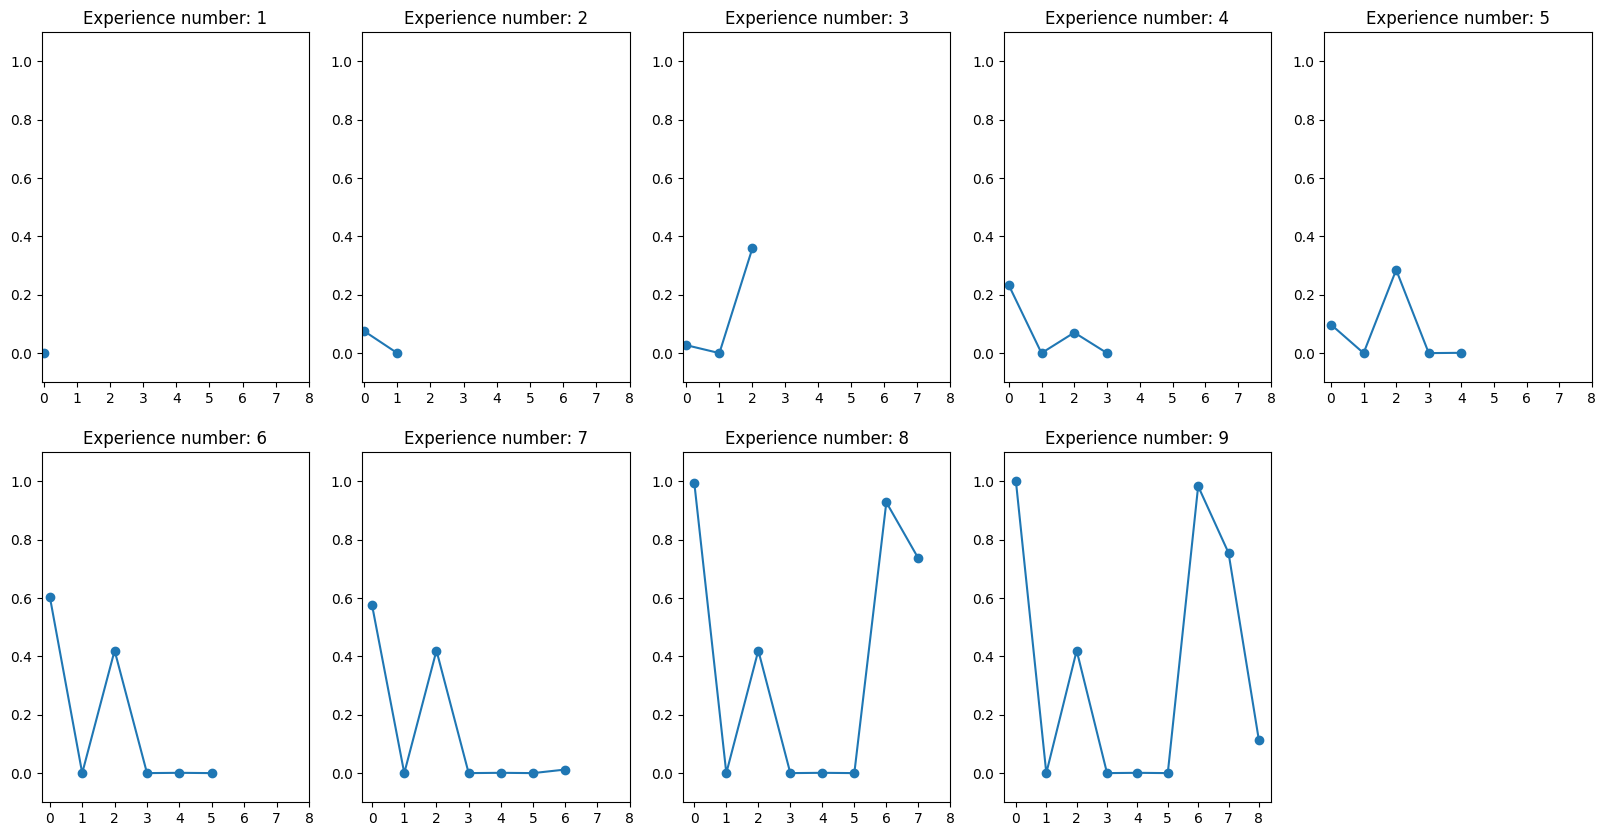

In [ ]:
NC_EWC_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NC_EWC_FORG_matrix.append(forg)
    i = i + 1

NC_EWC_FORG_matrix = NC_EWC_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_EWC_FORG_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,9)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NC_EWC_FORG. pdf", format = "pdf")
plt.show()

<p align="justify"> Increasing the value of <i>mem_size</i> in the ReplayPlugin improves the performance of the model. This is because a larger memory buffer allows the model to store more data from previous tasks, which helps the model to learn from previous tasks and avoid forgetting what it has learned. When the value of mem_size is large enough, the approach becomes cumulative.

### Copy-weights with Re-init
---

In [ ]:
from avalanche.training.supervised import CWRStar

In [ ]:
%%capture
# Create a SimpleMLP model with the number of classes in the scenario
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# Define evaluation loggers for different outputs]
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file
interactive_logger = InteractiveLogger()  # Print to stdout (interactive)

# Define an EvaluationPlugin that manages metric computation and output
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


# Create a Naive continual learning strategy instance
cl_strategy = CWRStar(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    cwr_layer_name = 'network.12',
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    evaluator = eval_plugin
)

In [ ]:
for name, m in model.named_modules():
  print(name, m)

 MoodyRoosterNET(
  (network): Sequential(
    (0): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.05, inplace=False)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (6): Dropout2d(p=0.2, inplace=False)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=576, out_features=86, bias=True)
    (11): ReLU()
    (12): Linear(in_features=86, out_features=10, bias=True)
  )
)
network Sequential(
  (0): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (1): Dropout2d(p=0.05, inplace=False)
  (2): ReLU()
  (3): Conv2d(4, 8, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (6): Dropout2d(p=0.2, inplace=

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [2]
100%|██████████| 60/60 [00:03<00:00, 15.50it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:01<00:00, 10.24it/s]
Start of experience:  1
Current Classes:  [6]
100%|██████████| 60/60 [00:04<00:00, 14.11it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 15.99it/s]
Start of experience:  2
Current Classes:  [1]
100%|██████████| 68/68 [00:03<00:00, 20.94it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:00<00:00, 17.62it/s]
Start of experience:  3
Current Classes:  [8]
100%|██████████| 59/59 [00:02<00:00, 24.53it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 11/11 [00:01<00:00,  9.68it/s]
Start of experience:  4
Current Classes:  [4]
100%|██████████| 59/59 [00:02<00:00, 23.51it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████

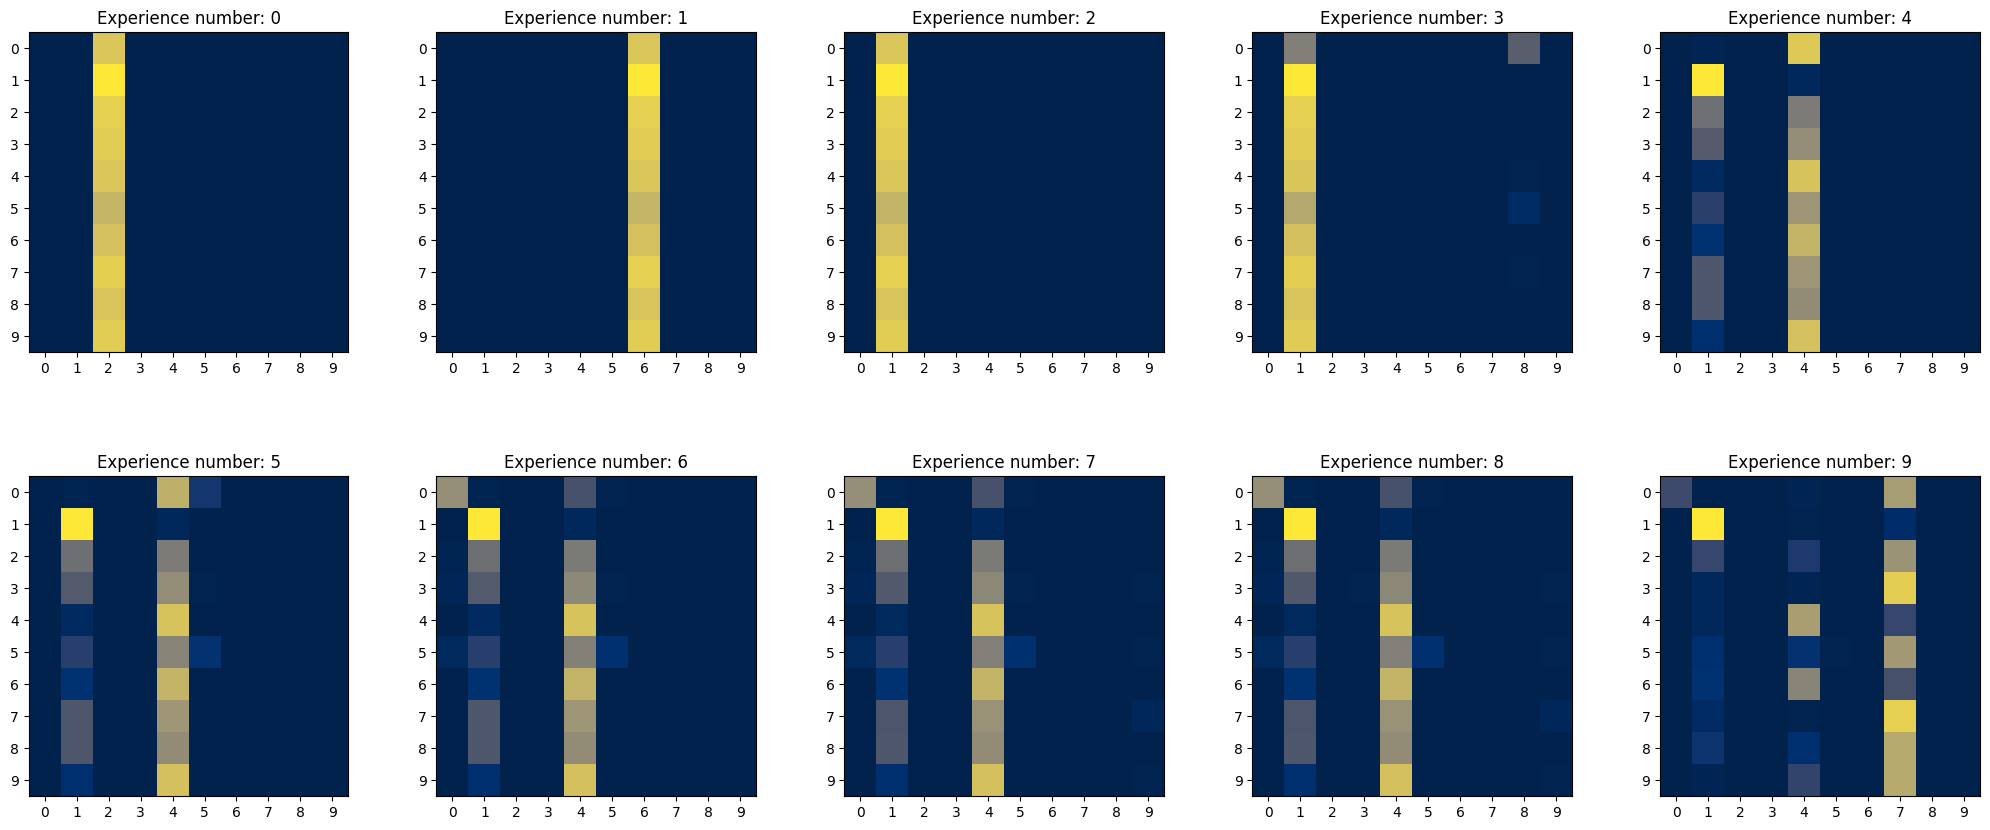

In [ ]:
NC_CWR_cf_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2, 5, i+1)
  NC_CWR_cf_matrix.append(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt. savefig("NC_CWR_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

In [ ]:
# The ExperienceForgetting metric, describing the accuracy loss
# detected for a certain experience.
# This plugin metric, computed separately for each experience,
# is the difference between the accuracy result obtained after
# first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.



# The StreamForgetting metric, describing the average evaluation accuracy loss
# detected over all experiences observed during training.
# This plugin metric, computed over all observed experiences during training,
# is the average over the difference between the accuracy result obtained
# after first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.

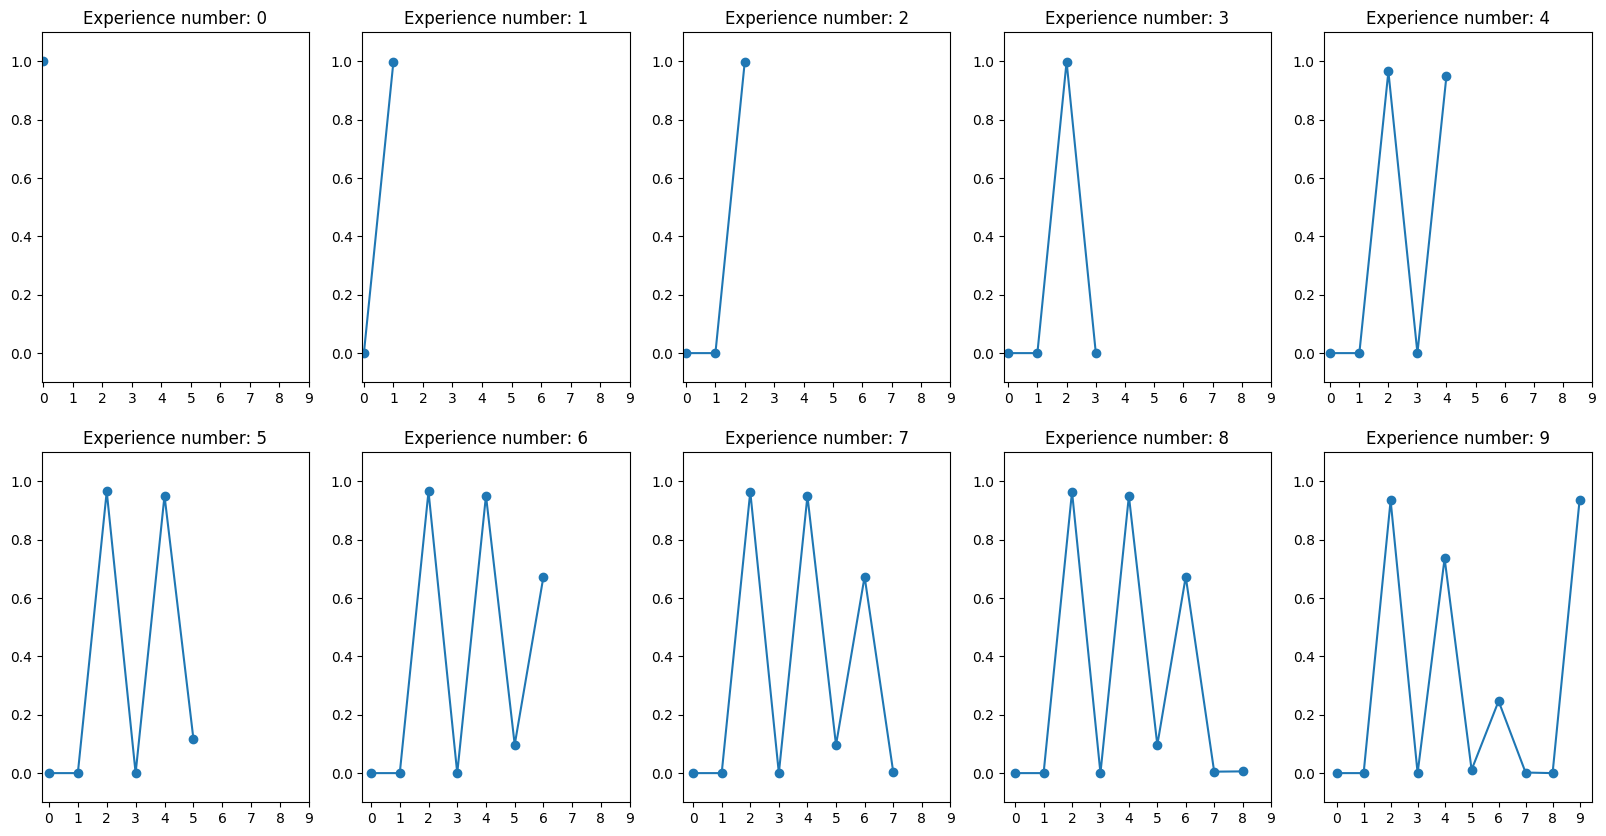

In [ ]:
NC_CWR_acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NC_CWR_acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_CWR_acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')

plt. savefig("NC_CWR_ACC. pdf", format = "pdf")
plt.show()

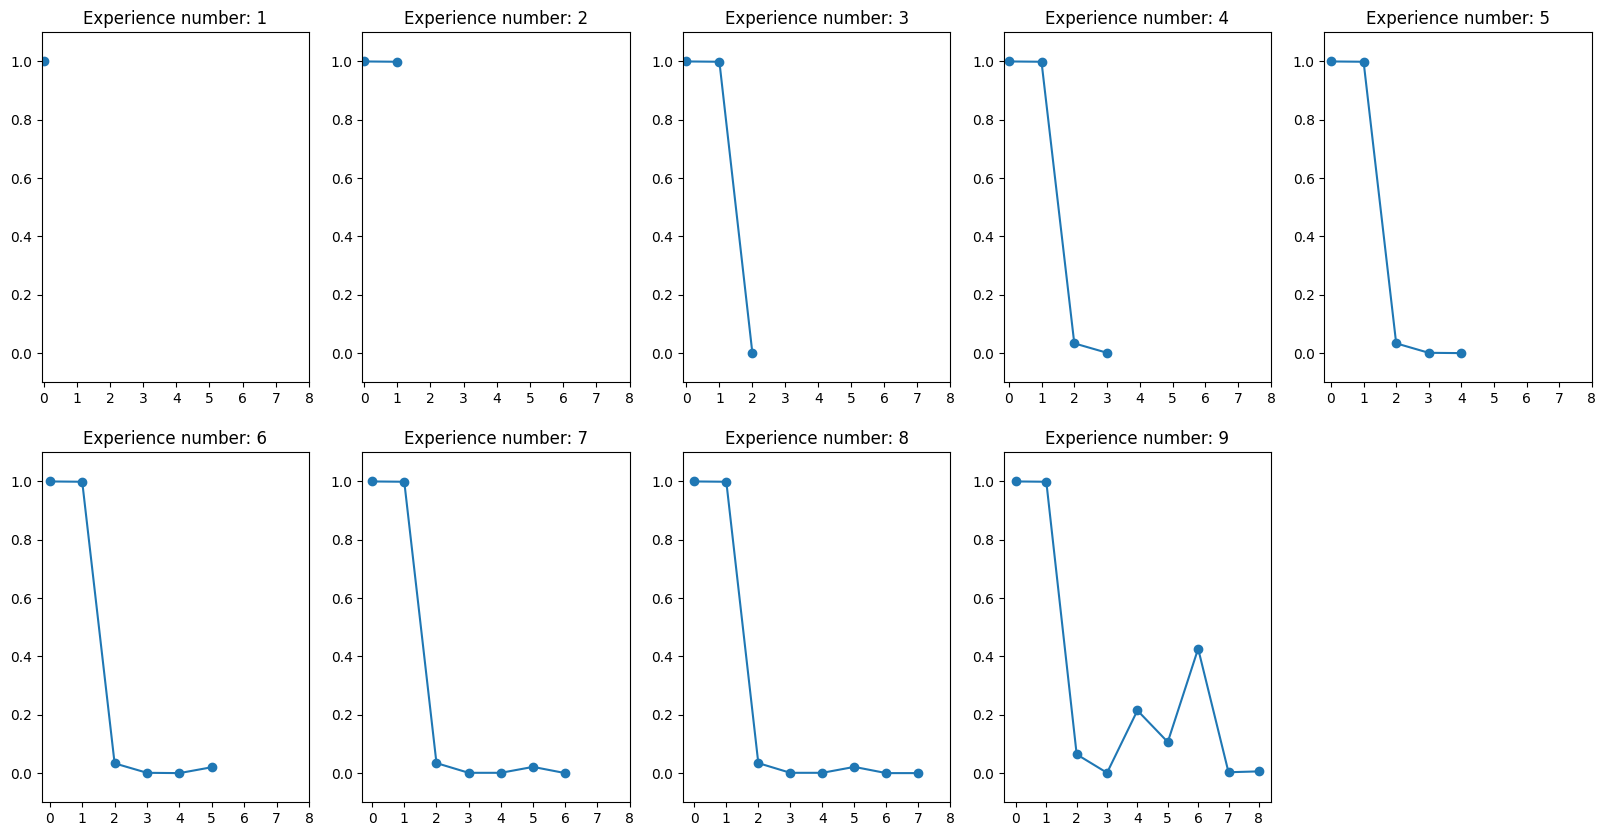

In [ ]:
NC_CWR_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NC_CWR_FORG_matrix.append(forg)
    i = i + 1

NC_CWR_FORG_matrix = NC_CWR_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(NC_CWR_FORG_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,9)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NC_CWR_FORG. pdf", format = "pdf")
plt.show()

### Results
---

In [ ]:
labels = ['Naive Approach', 'Cumulative Approach', 'Replay Approach', 'Elastic Weights Consolidation Approach', 'Copy-weights with Re-init']

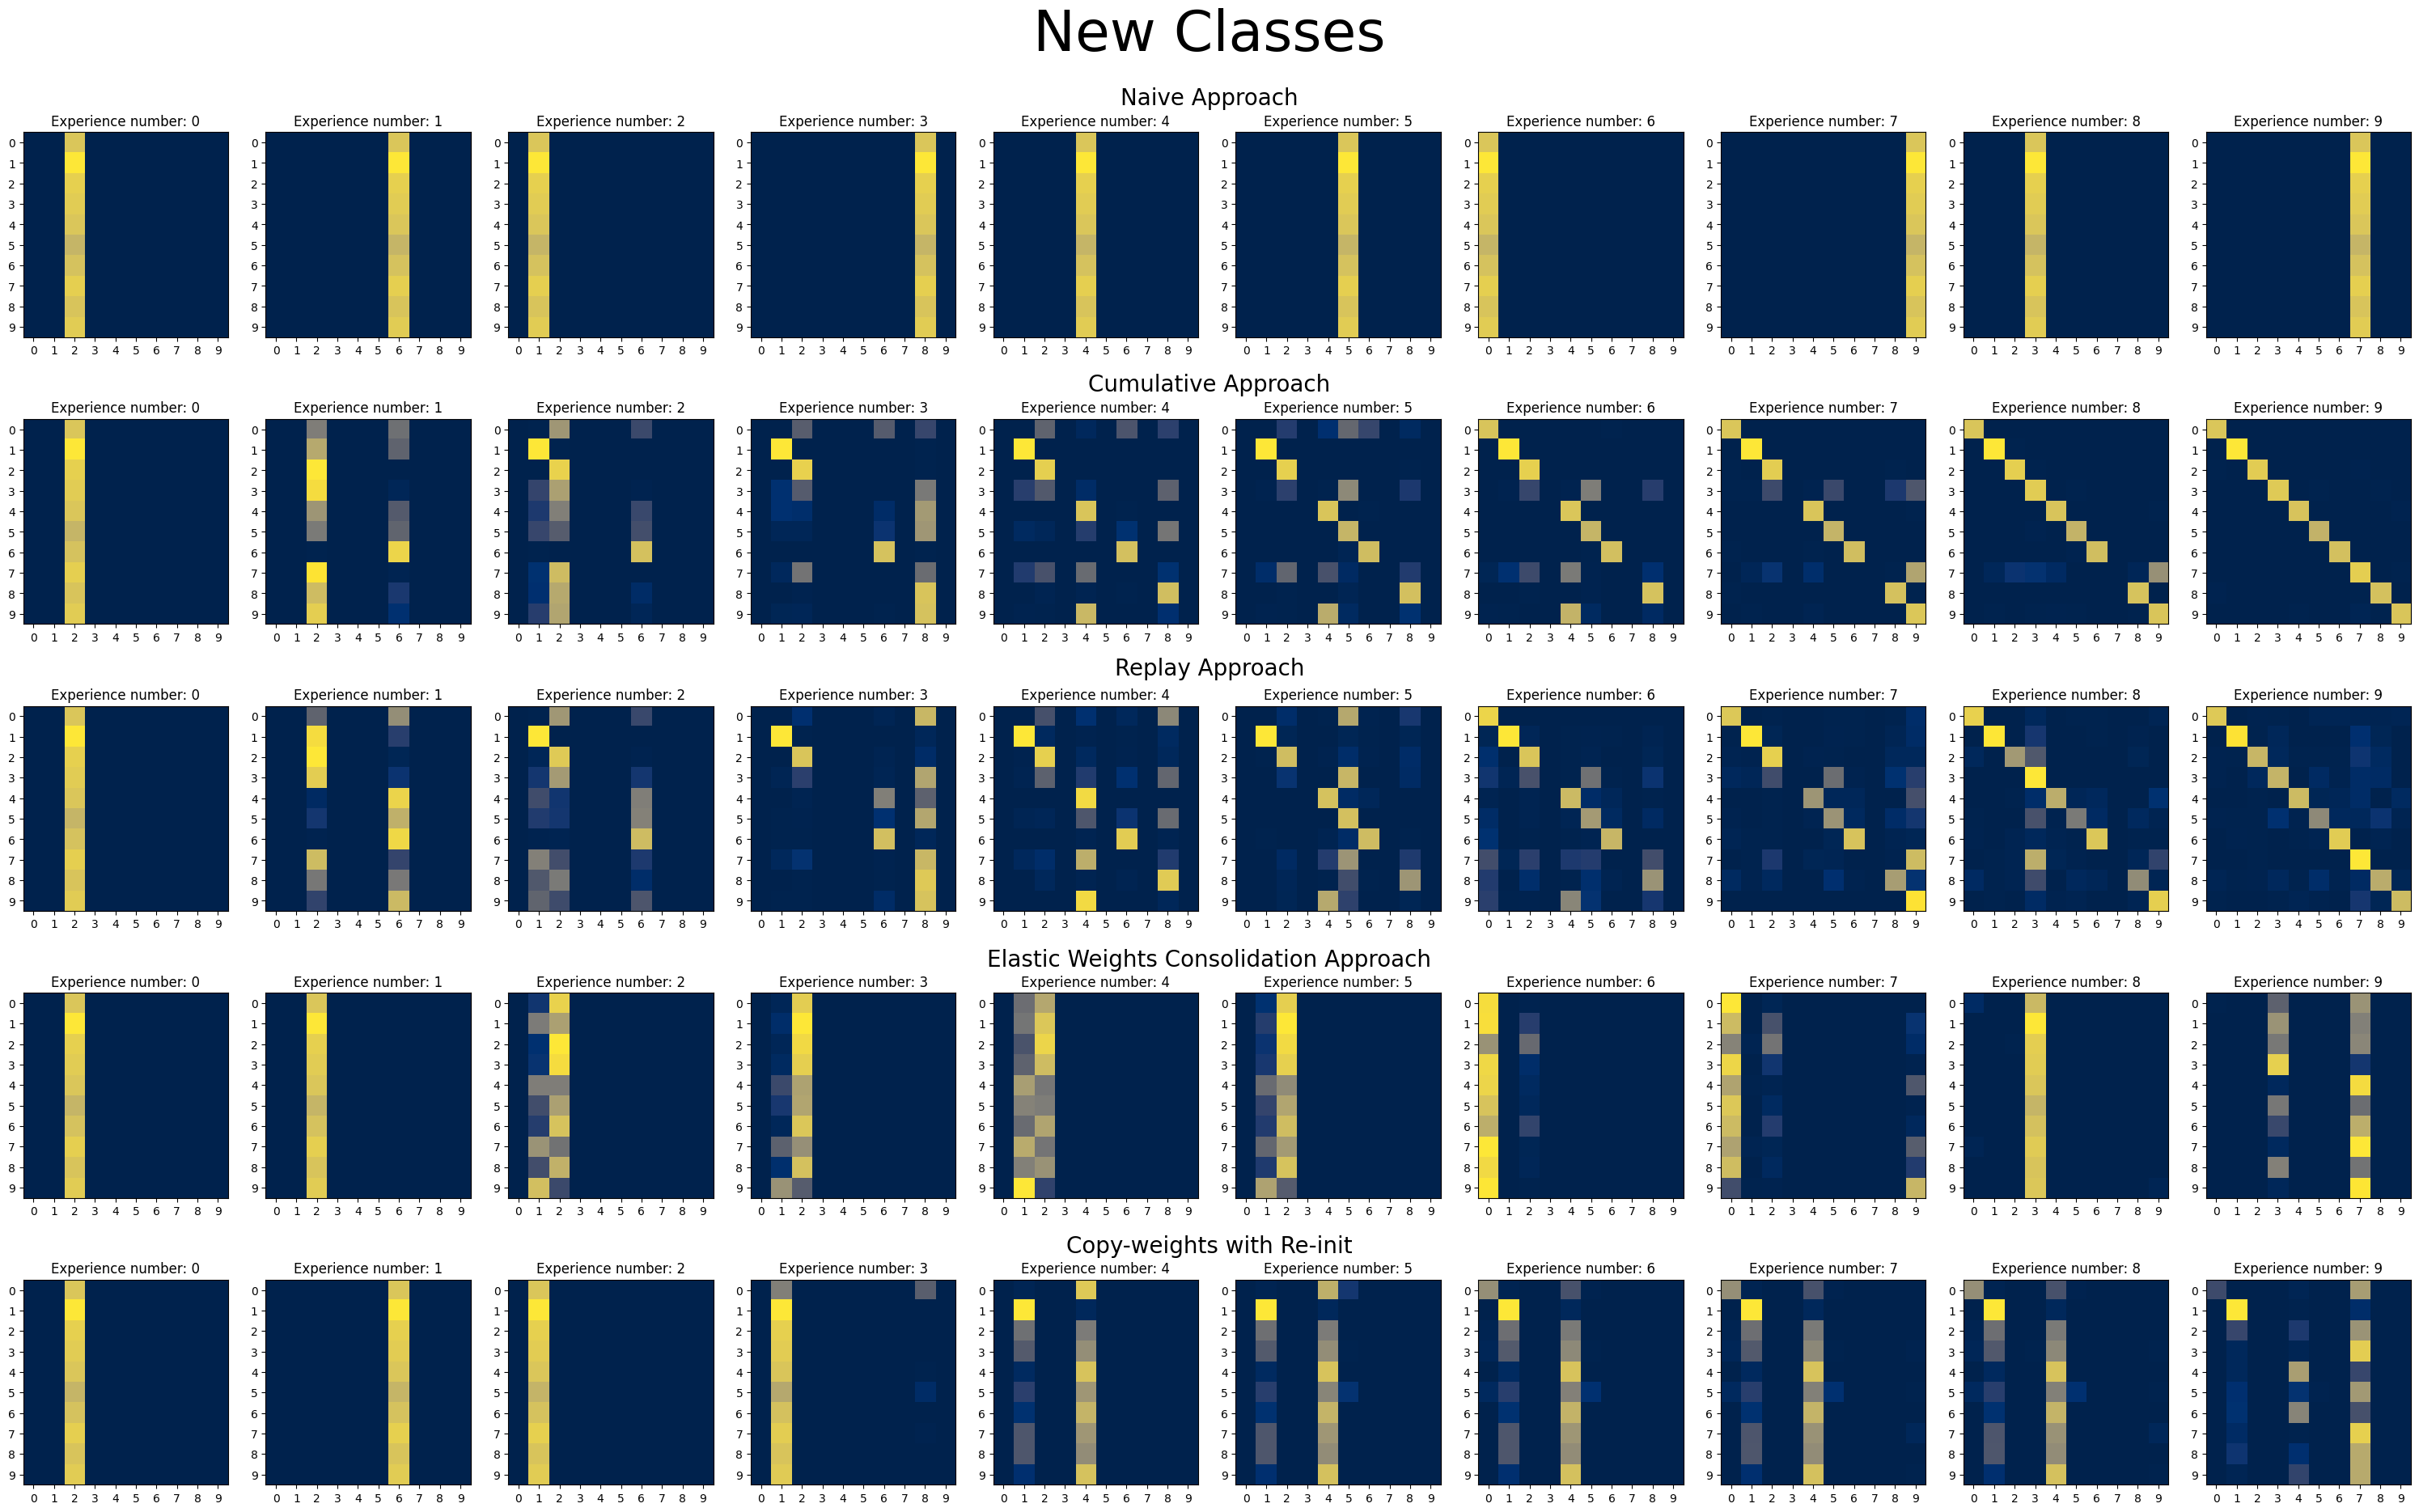

In [ ]:
CF_PLOT = []
CF_PLOT.append(NC_NA_cf_matrix)
CF_PLOT.append(NC_CA_cf_matrix)
CF_PLOT.append(NC_RA_cf_matrix)
CF_PLOT.append(NC_EWC_cf_matrix)
CF_PLOT.append(NC_CWR_cf_matrix)

fig = plt.figure(figsize = (30,30))

n_col = len(CF_PLOT)
n_row = len(CF_PLOT[0])

k = 0
for j in range(0, n_col):
  for i in range(0, n_row):
    k = k+1
    plt.subplot(n_col, n_row, k)
    plt.imshow(CF_PLOT[j][i], cmap = 'cividis', interpolation = 'none')
    plt.title("Experience number: {}".format(str(i)))
    plt.xticks(list(range(10)))
    plt.yticks(list(range(10)))
    fig.set_facecolor('white')

fig.text(.5, 0.79, labels[0], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.672, labels[1], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.555, labels[2], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.435, labels[3], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.317, labels[4], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.tight_layout(h_pad = -75, w_pad = 2)
fig.suptitle('New Classes', y = 0.83, fontsize = 50, fontweight = 'roman')
plt.savefig(f"{images_dir}/NC_CF.pdf", format = "pdf")
plt.show()

In [ ]:
ACC_PLOT = []
ACC_PLOT.append(NC_NA_acc_matrix)
ACC_PLOT.append(NC_CA_acc_matrix)
ACC_PLOT.append(NC_RA_acc_matrix)
ACC_PLOT.append(NC_EWC_acc_matrix)
ACC_PLOT.append(NC_CWR_acc_matrix)

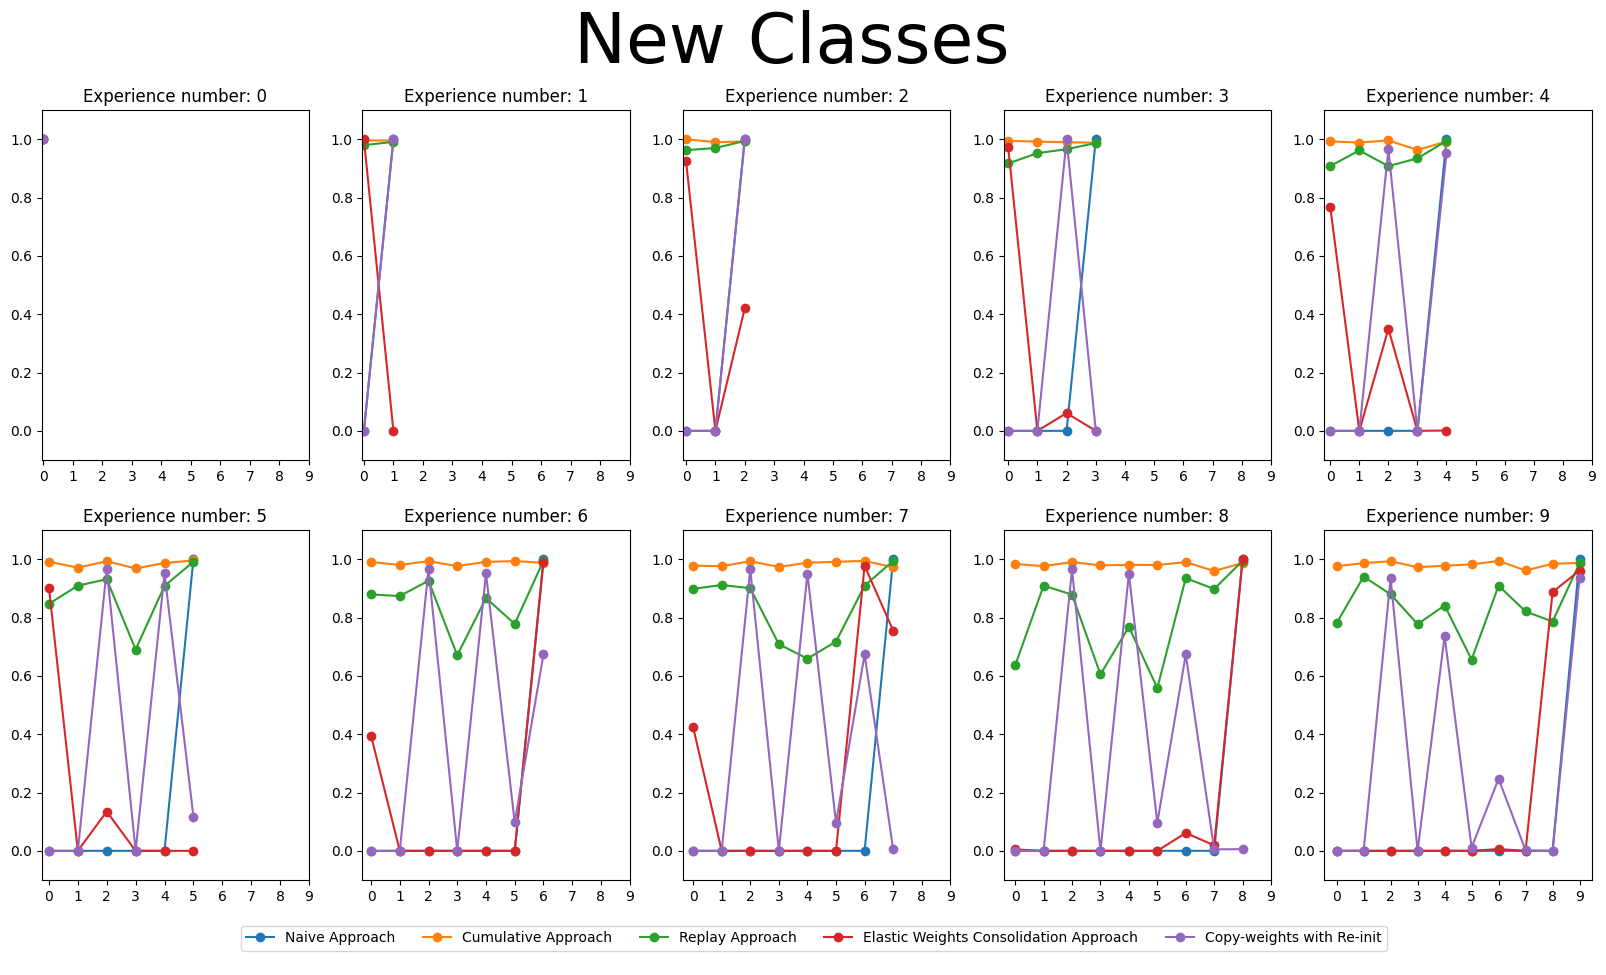

In [ ]:
fig = plt.figure(figsize = (20,10))
for j in range(0, len(ACC_PLOT)):

  for i,r in enumerate(ACC_PLOT[j]):
    plt.subplot(2,5,i+1)
    plt.plot(r[:i+1], 'o-')
    plt.ylim(-0.1,1.1)
    plt.title("Experience number: {}".format(str(i)))
    plt.xticks(list(range(10)))

    fig.set_facecolor('white')

plt.figlegend(labels, loc = (0.15, 0.025), ncol = 5, labelspacing = 0.)
fig.suptitle('New Classes', y = 0.98, fontsize = 50, fontweight = 'roman')
plt.savefig(f"{images_dir}/NC_ACC. pdf", format = "pdf")
plt.show()

In [ ]:
FORG_PLOT = []
FORG_PLOT.append(NC_NA_FORG_matrix)
FORG_PLOT.append(NC_CA_FORG_matrix)
FORG_PLOT.append(NC_RA_FORG_matrix)
FORG_PLOT.append(NC_EWC_FORG_matrix)
FORG_PLOT.append(NC_CWR_FORG_matrix)

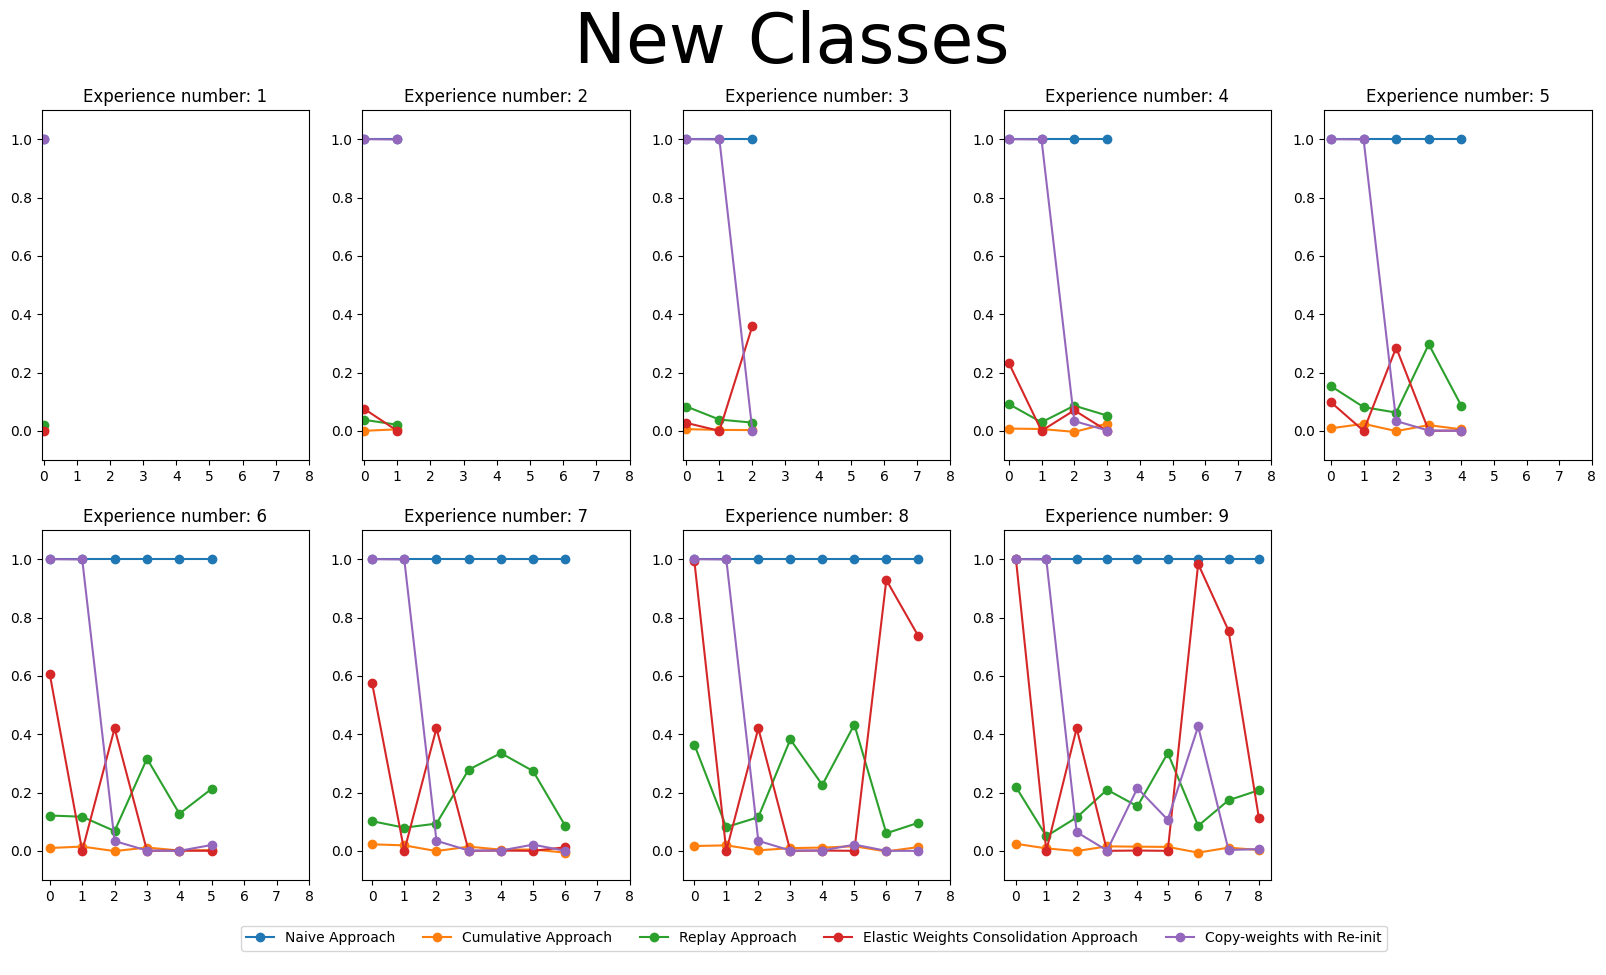

In [ ]:
fig = plt.figure(figsize = (20,10))
for j in range(0, len(FORG_PLOT)):

  for i,r in enumerate(FORG_PLOT[j]):
    plt.subplot(2,5,i+1)
    plt.plot(r[:i+1], 'o-')
    plt.ylim(-0.1,1.1)
    plt.title("Experience number: {}".format(str(i+1)))
    plt.xticks(list(range(9)))

    fig.set_facecolor('white')

plt.figlegend(labels, loc = (0.15, 0.025), ncol = 5, labelspacing = 0.)
fig.suptitle('New Classes', y = 0.98, fontsize = 50, fontweight = 'roman')
plt.savefig(f"{images_dir}/NC_FORG. pdf", format = "pdf")
plt.show()

## *New Instances*
---
<p align = 'justify'> As said before, another problem that continual learning wants to tackles is the issue of having new instances where the rappresentation of the class may change. Examples took from the real world may be more intuitive than the one I will be using in this notebook. For example, let's imagine that we live in world where just standard chars, four legs and one back, exist. We want to build a network that learns what chair is, we feed it pictures of all the existing chairs in the world, the network now performs an excellent job. But one day, a bad person arrives, he is too creative and decides to build a different chair, eight legs and no back, a product of design. The human eye promptly that it is a chair and it is meant for support our lower back, but our network trembles facing this new creation, is it a spider? is it a table? it doesn't know.
Since we are lazy and the dataset of the all existing chairs is big we don't want to retrain from scratch, but change the net knowledge based on the new instance.

<p align = 'justify'> For this problem I will use the PermutedMNIST dataset, where the pixel of the digitis are permuted randomly across the image generating a new representation for the object.

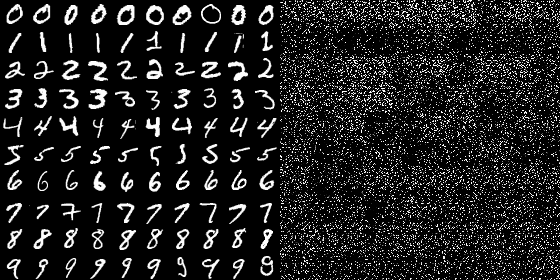

### Naive Approach
---

In [ ]:
from avalanche.benchmarks.classic import PermutedMNIST

In [ ]:
scenario.train_stream[0]

In [ ]:
%%capture
# Create a SplitMNIST scenario with 10 experiences (classes)
scenario = PermutedMNIST(n_experiences = 5, seed = random_seed)

# Create a SimpleMLP model with the number of classes in the scenario
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# Define evaluation loggers for different outputs]
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file
interactive_logger = InteractiveLogger()  # Print to stdout (interactive)

# Define an EvaluationPlugin that manages metric computation and output
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


# Create a Naive continual learning strategy instance
cl_strategy = Naive(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    evaluator = eval_plugin
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:47<00:00, 12.51it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 19.02it/s]
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:46<00:00, 13.01it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:07<00:00, 13.35it/s]
Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:49<00:00, 12.14it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:06<00:00, 15.94it/s]
Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:46<00:00, 12.89it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:08<00:00, 12.31it/s]
Start of experience:  4
Current Classes:  [0,

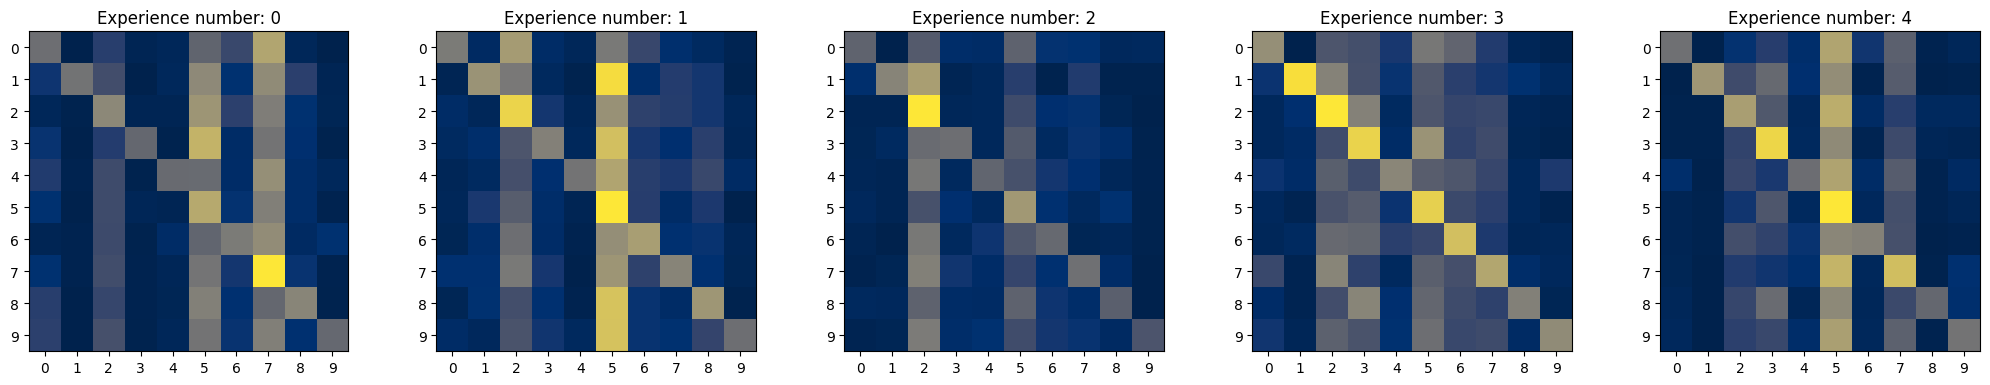

In [ ]:
NI_NA_CF_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(1, 5, i+1)
  df = pd.DataFrame(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  df.drop(df.index[10:], inplace = True)
  df.drop(df.iloc[:, 10:], axis = 1, inplace = True)
  NI_NA_CF_matrix.append(df)
  plt.imshow(df, cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_NA_CF.pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

In [ ]:
# The ExperienceForgetting metric, describing the accuracy loss
# detected for a certain experience.
# This plugin metric, computed separately for each experience,
# is the difference between the accuracy result obtained after
# first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.



# The StreamForgetting metric, describing the average evaluation accuracy loss
# detected over all experiences observed during training.
# This plugin metric, computed over all observed experiences during training,
# is the average over the difference between the accuracy result obtained
# after first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.

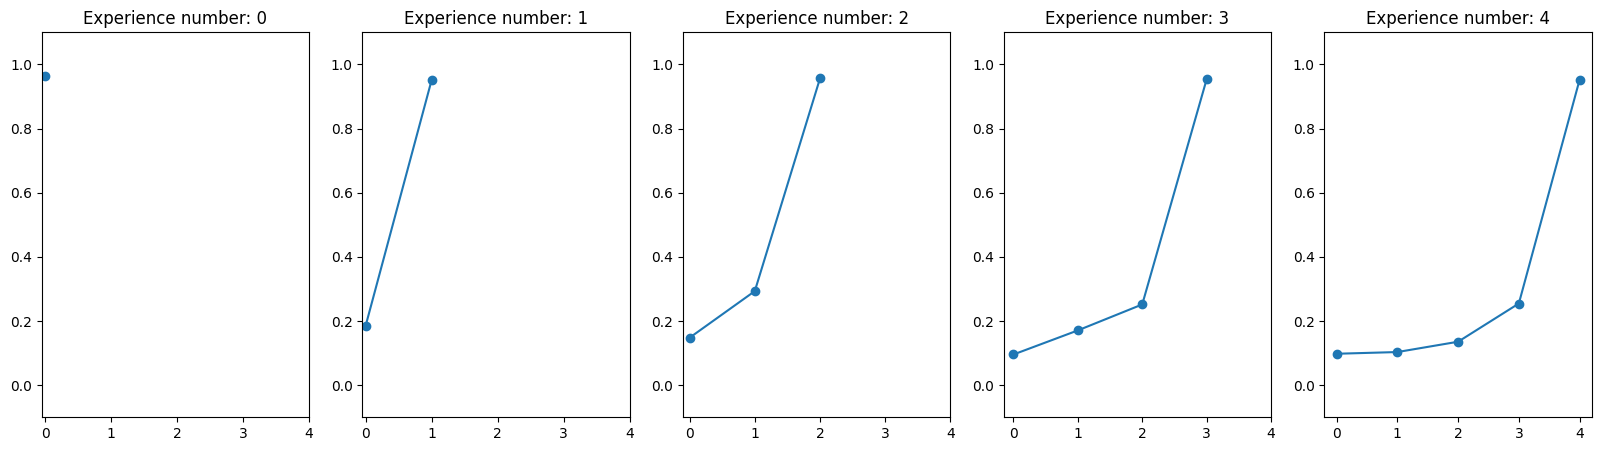

In [ ]:
keys = list(results[0].keys())
acc_keys = [n for n in keys if n[:-1] == 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00']


NI_NA_ACC_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NI_NA_ACC_matrix.append(acc)

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_NA_ACC_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(5)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_NA_ACC.pdf", format = "pdf")
plt.show()

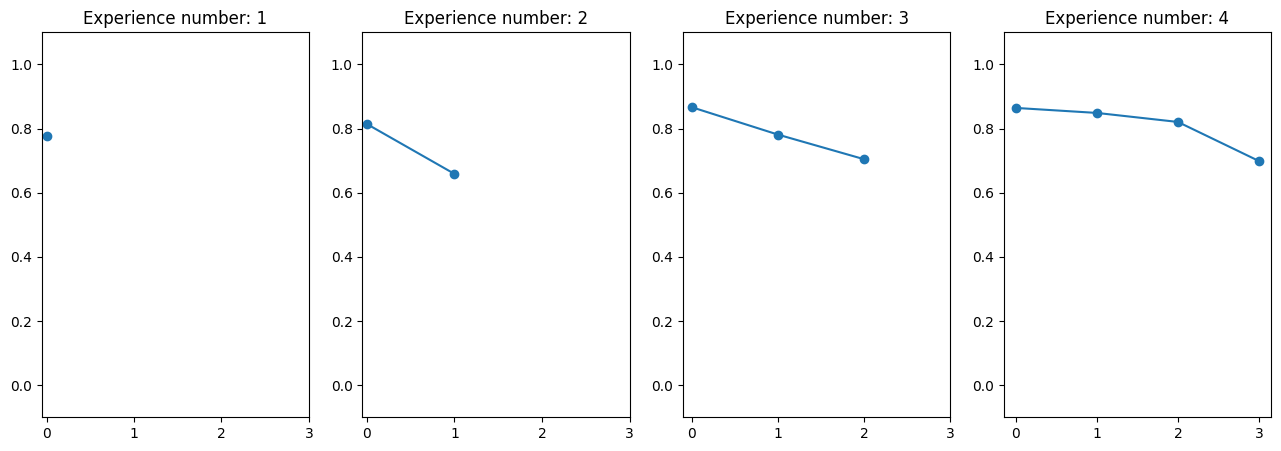

In [ ]:
keys = list(results[4].keys())
forg_keys = [n for n in keys if n[:-1] == 'ExperienceForgetting/eval_phase/test_stream/Task000/Exp00']

NI_NA_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NI_NA_FORG_matrix.append(forg)
    i = i + 1

NI_NA_FORG_matrix = NI_NA_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_NA_FORG_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,4)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NI_NA_FORG. pdf", format = "pdf")
plt.show()

### Cumulative Approach
---

In [ ]:
%%capture
# Create a SimpleMLP model with the number of classes in the scenario
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# Define evaluation loggers for different outputs]
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file
interactive_logger = InteractiveLogger()  # Print to stdout (interactive)

# Define an EvaluationPlugin that manages metric computation and output
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


# Create a Naive continual learning strategy instance
cl_strategy = Cumulative(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    evaluator = eval_plugin
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:49<00:00, 12.20it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 16.79it/s]
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 1200/1200 [01:38<00:00, 12.16it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 17.17it/s]
Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 1800/1800 [02:23<00:00, 12.54it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:04<00:00, 21.81it/s]
Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 2400/2400 [03:10<00:00, 12.57it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:06<00:00, 16.16it/s]
Start of experience:  4
Current Classes

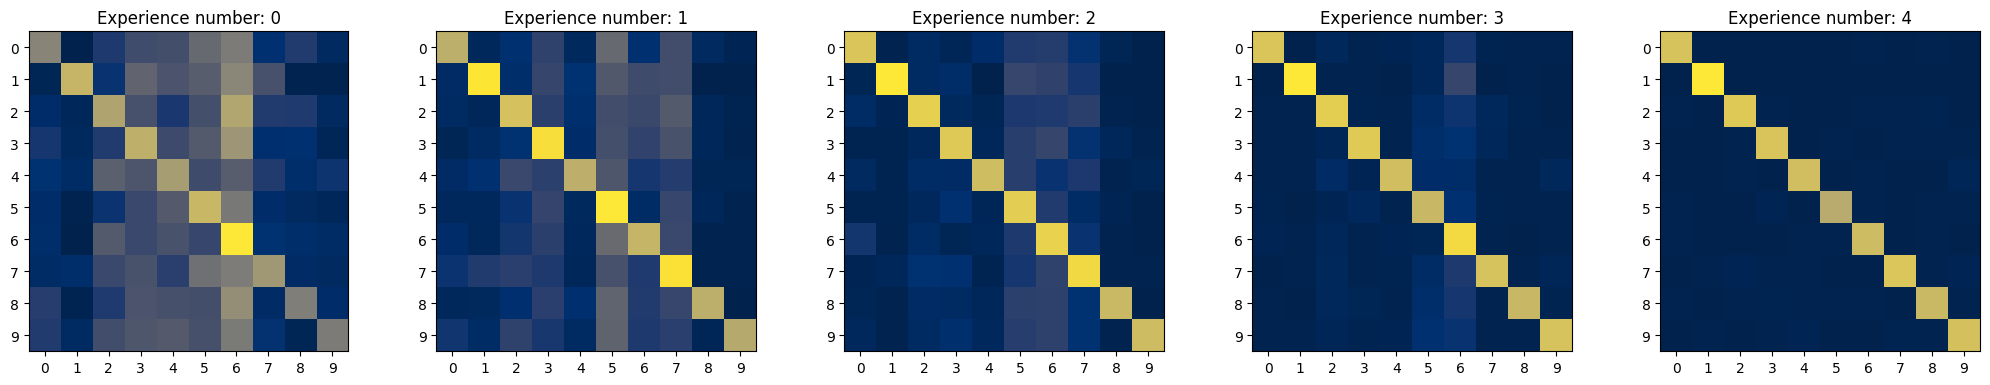

In [ ]:
NI_CA_CF_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(1, 5, i+1)
  df = pd.DataFrame(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  df.drop(df.index[10:], inplace = True)
  df.drop(df.iloc[:, 10:], axis = 1, inplace = True)
  NI_CA_CF_matrix.append(df)
  plt.imshow(df, cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_CA_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

In [ ]:
# The ExperienceForgetting metric, describing the accuracy loss
# detected for a certain experience.
# This plugin metric, computed separately for each experience,
# is the difference between the accuracy result obtained after
# first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.



# The StreamForgetting metric, describing the average evaluation accuracy loss
# detected over all experiences observed during training.
# This plugin metric, computed over all observed experiences during training,
# is the average over the difference between the accuracy result obtained
# after first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.

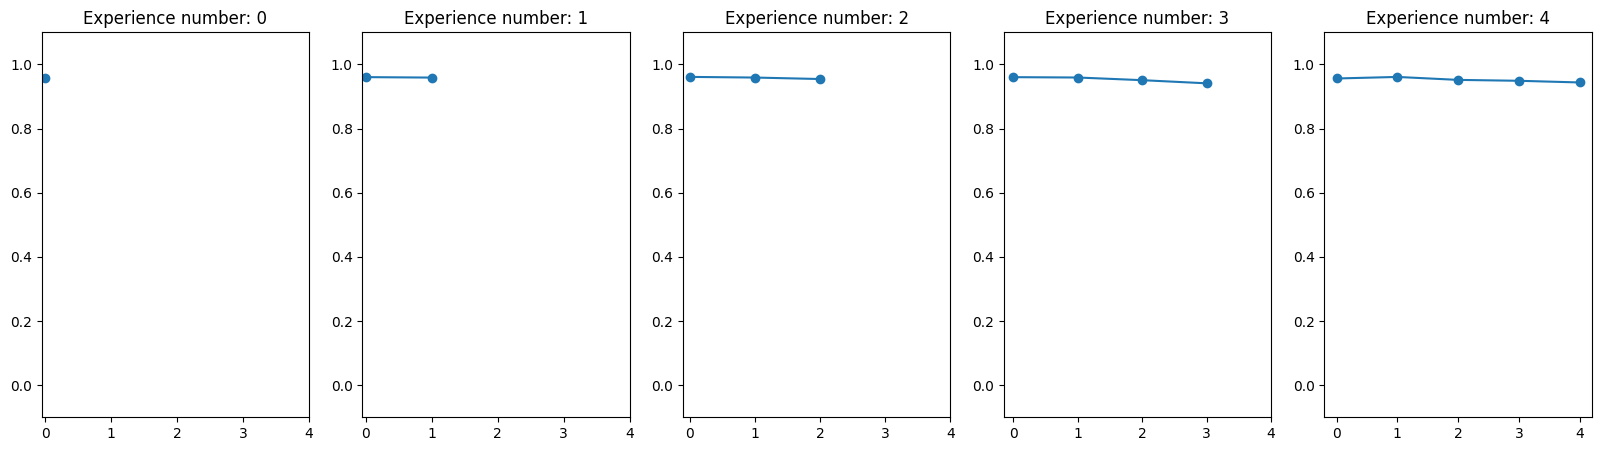

In [ ]:
NI_CA_ACC_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NI_CA_ACC_matrix.append(acc)

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_CA_ACC_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(5)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_CA_ACC. pdf", format = "pdf")
plt.show()

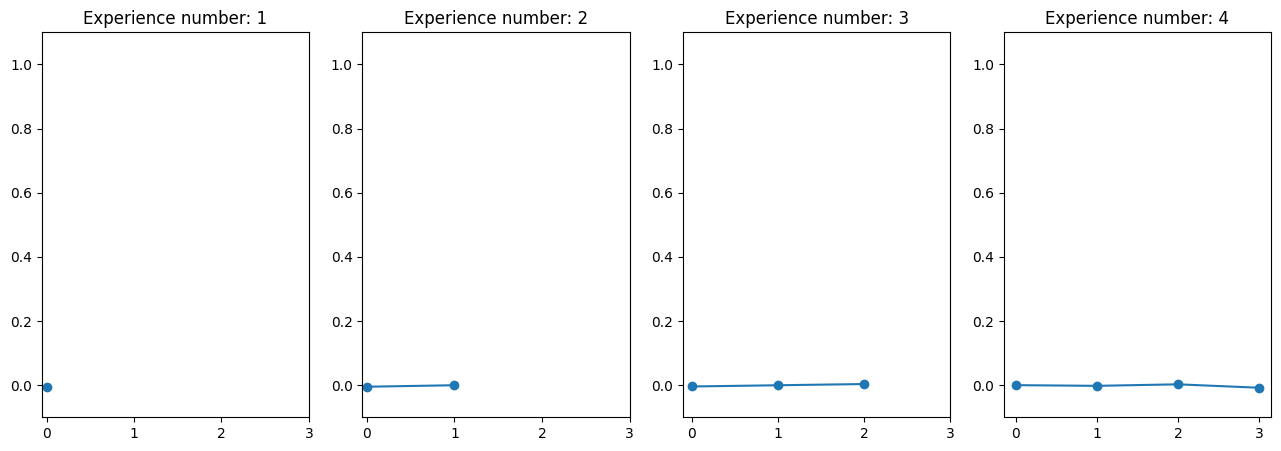

In [ ]:
NI_CA_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NI_CA_FORG_matrix.append(forg)
    i = i + 1

NI_CA_FORG_matrix = NI_CA_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_CA_FORG_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,4)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NI_CA_FORG. pdf", format = "pdf")
plt.show()

### Replay Approach
---

In [ ]:
%%capture
model = MoodyRoosterNET(num_classes = scenario.n_classes)

replay = ReplayPlugin(mem_size = 100)

# choose some metrics and evaluation method
interactive_logger = InteractiveLogger()
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


cl_strategy = SupervisedTemplate(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    plugins=[replay],
    evaluator = eval_plugin,
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:45<00:00, 13.14it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:07<00:00, 14.14it/s]
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [01:27<00:00,  6.83it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:07<00:00, 13.24it/s]
Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [01:27<00:00,  6.87it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:04<00:00, 21.93it/s]
Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [01:24<00:00,  7.08it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 16.84it/s]
Start of experience:  4
Current Classes:  [0,

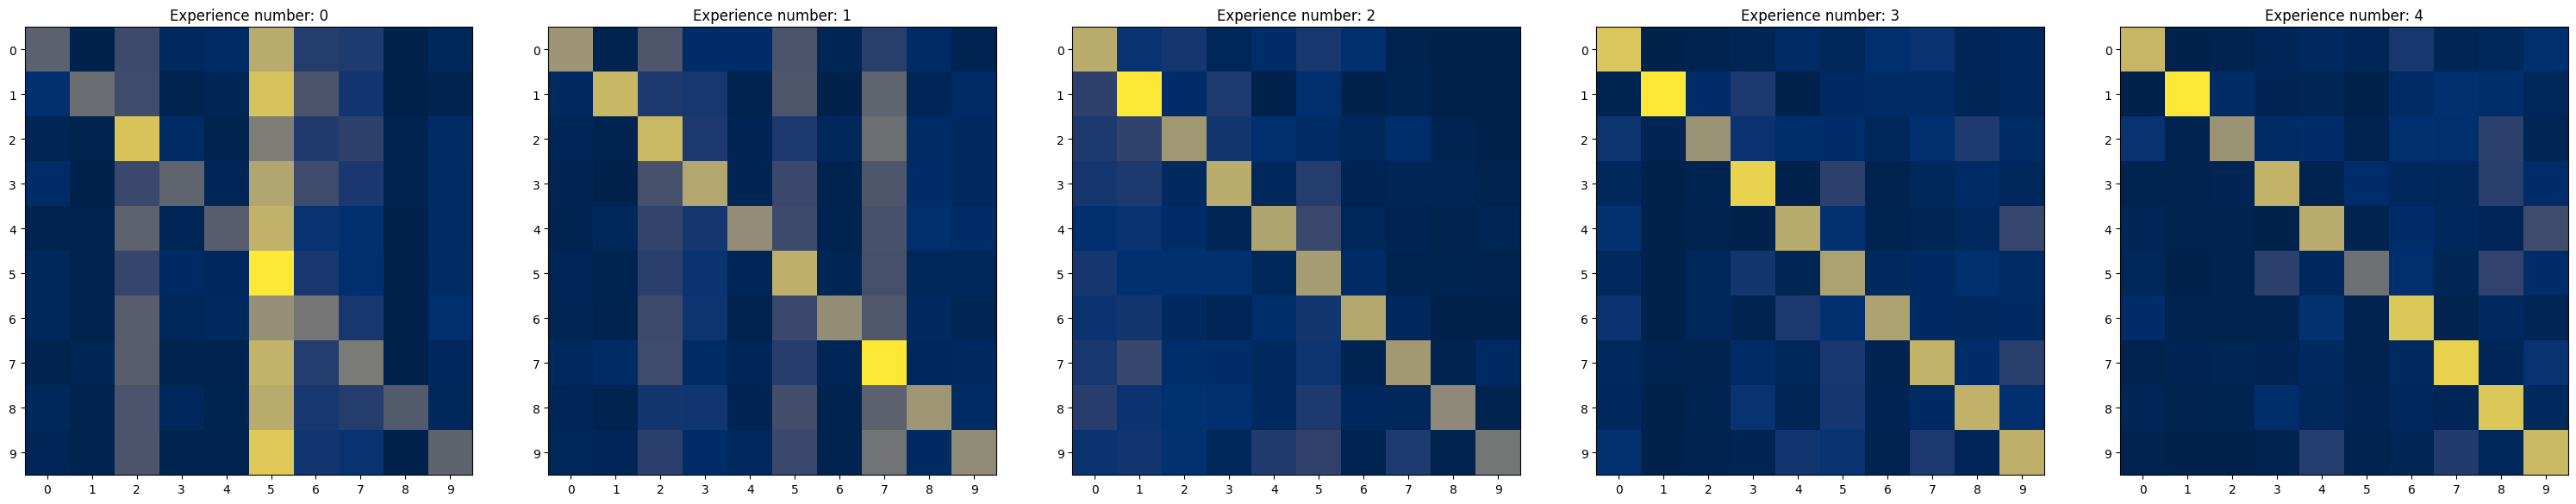

In [ ]:
NI_RA_CF_matrix = []

fig = plt.figure(figsize = (30,30))
for i,r in enumerate(results):
  plt.subplot(1, 5, i+1)

  df = pd.DataFrame(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  df.drop(df.index[10:], inplace = True)
  df.drop(df.iloc[:, 10:], axis = 1, inplace = True)
  NI_RA_CF_matrix.append(df)
  plt.imshow(df, cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_RA_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

In [ ]:
# The ExperienceForgetting metric, describing the accuracy loss
# detected for a certain experience.
# This plugin metric, computed separately for each experience,
# is the difference between the accuracy result obtained after
# first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.



# The StreamForgetting metric, describing the average evaluation accuracy loss
# detected over all experiences observed during training.
# This plugin metric, computed over all observed experiences during training,
# is the average over the difference between the accuracy result obtained
# after first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.

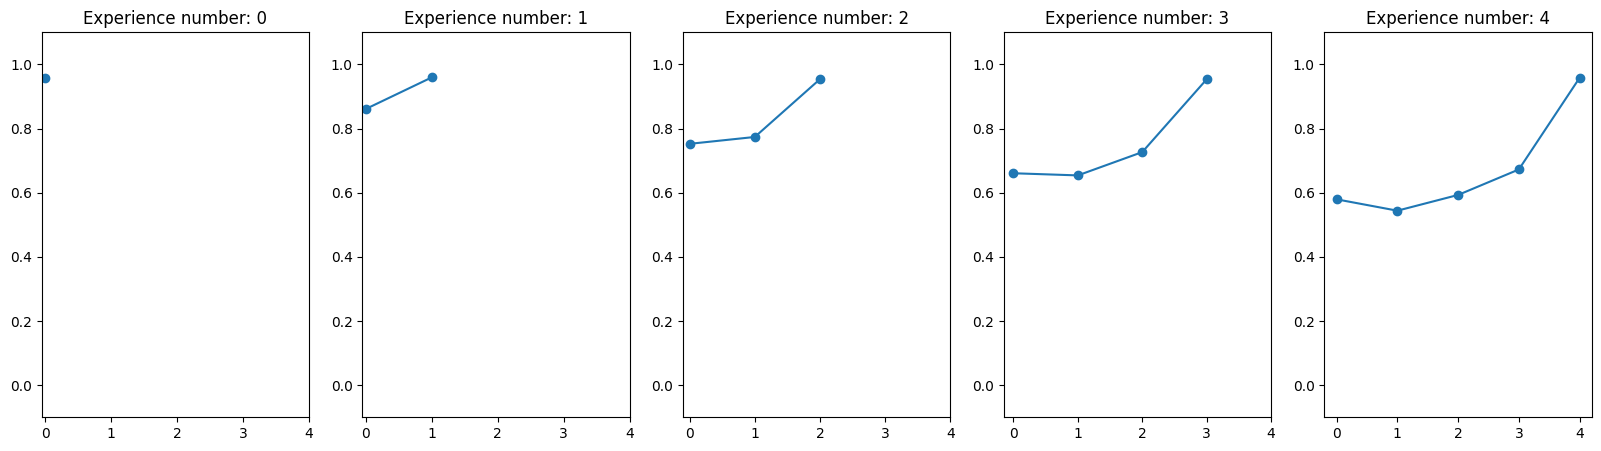

In [ ]:
NI_RA_ACC_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NI_RA_ACC_matrix.append(acc)

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_RA_ACC_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(5)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_RA_ACC. pdf", format = "pdf")
plt.show()

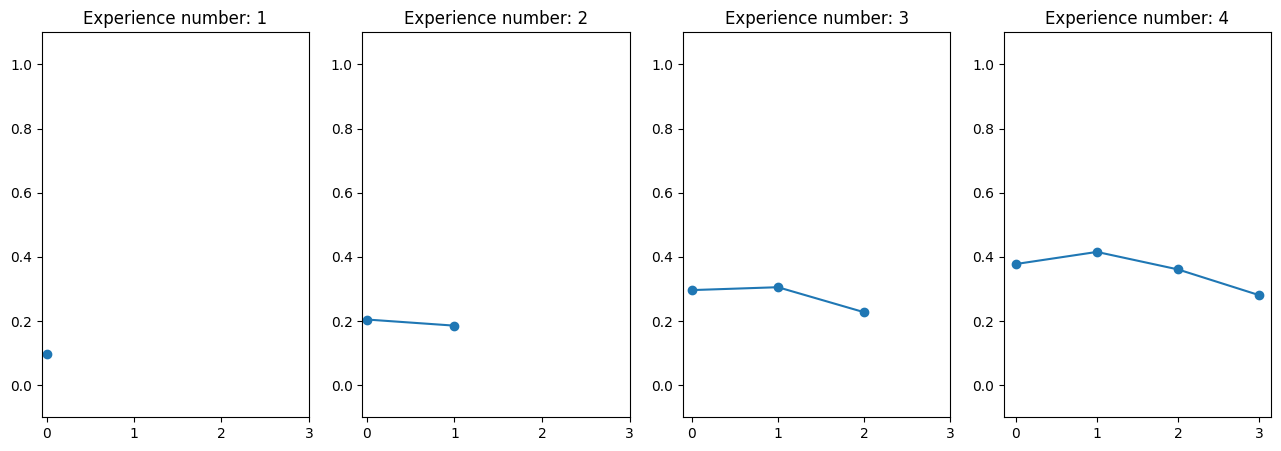

In [ ]:
NI_RA_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NI_RA_FORG_matrix.append(forg)
    i = i + 1

NI_RA_FORG_matrix = NI_RA_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_RA_FORG_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,4)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NI_RA_FORG. pdf", format = "pdf")
plt.show()

### Elastic Weight Consolidation Approach
---

In [ ]:
%%capture
# Create a SimpleMLP model with the number of classes in the scenario
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# Define evaluation loggers for different outputs]
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file
interactive_logger = InteractiveLogger()  # Print to stdout (interactive)

# Define an EvaluationPlugin that manages metric computation and output
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


# Create a Naive continual learning strategy instance
cl_strategy = EWC(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    ewc_lambda = 10,
    evaluator = eval_plugin,
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:48<00:00, 12.35it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 19.01it/s]
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:45<00:00, 13.05it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 19.47it/s]
Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:52<00:00, 11.53it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 19.07it/s]
Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:52<00:00, 11.37it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:04<00:00, 23.19it/s]
Start of experience:  4
Current Classes:  [0,

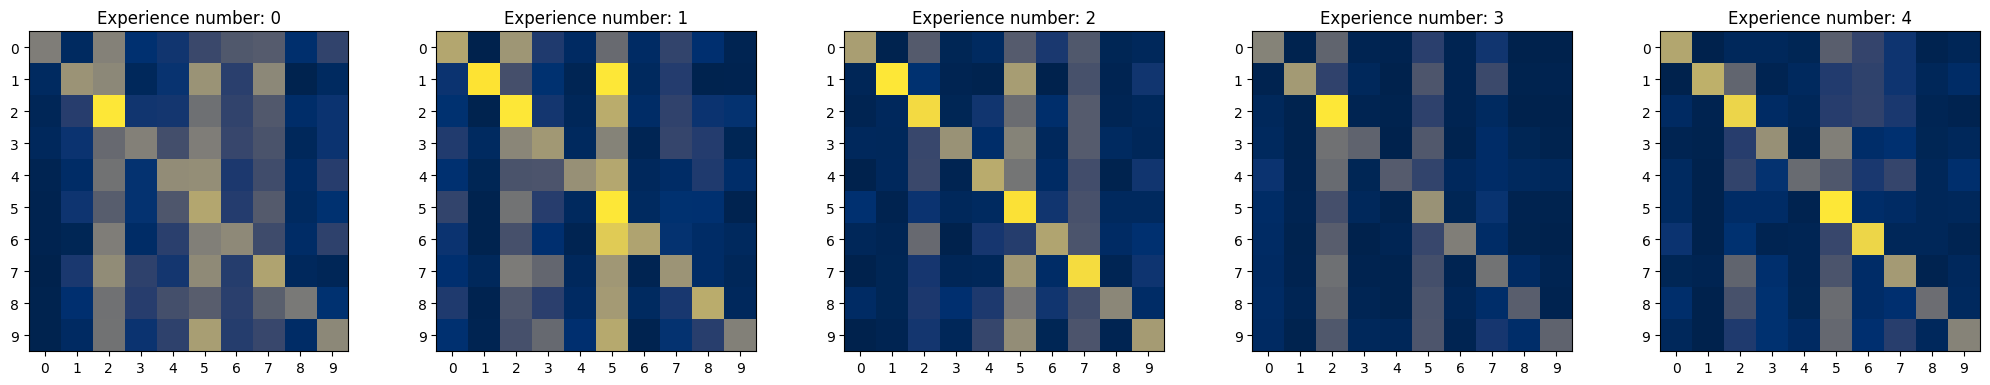

In [ ]:
NI_EWC_CF_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(1, 5, i+1)
  df = pd.DataFrame(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  df.drop(df.index[10:], inplace = True)
  df.drop(df.iloc[:, 10:], axis = 1, inplace = True)
  NI_EWC_CF_matrix.append(df)
  plt.imshow(df, cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_EWC_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

In [ ]:
# The ExperienceForgetting metric, describing the accuracy loss
# detected for a certain experience.
# This plugin metric, computed separately for each experience,
# is the difference between the accuracy result obtained after
# first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.



# The StreamForgetting metric, describing the average evaluation accuracy loss
# detected over all experiences observed during training.
# This plugin metric, computed over all observed experiences during training,
# is the average over the difference between the accuracy result obtained
# after first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.

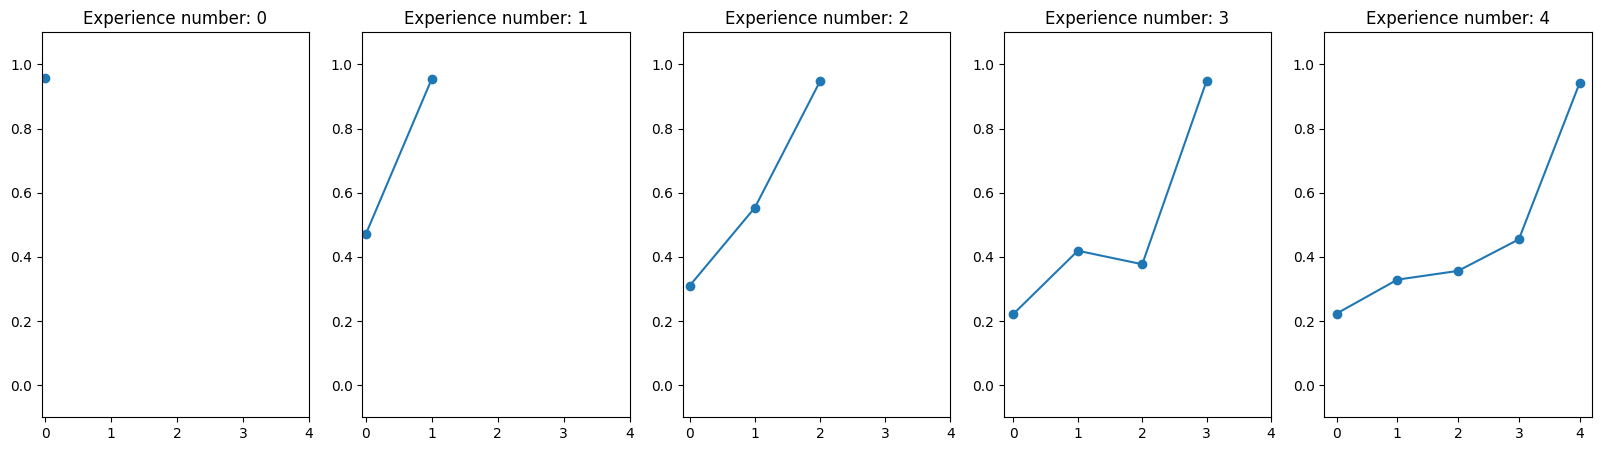

In [ ]:
NI_EWC_ACC_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NI_EWC_ACC_matrix.append(acc)

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_EWC_ACC_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(5)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_EWC_ACC. pdf", format = "pdf")
plt.show()

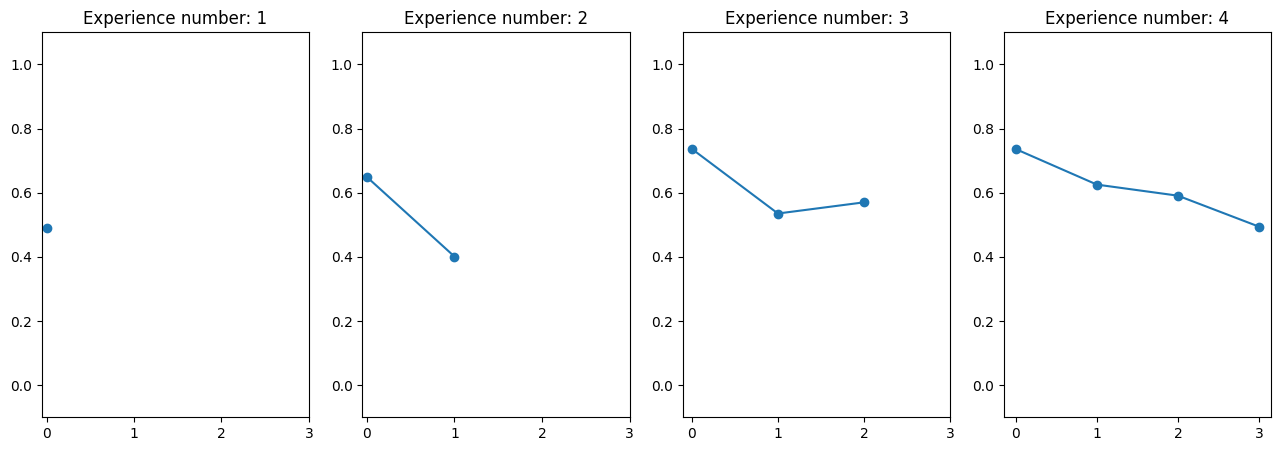

In [ ]:
NI_EWC_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NI_EWC_FORG_matrix.append(forg)
    i = i + 1

NI_EWC_FORG_matrix = NI_EWC_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_EWC_FORG_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,4)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NI_EWC_FORG. pdf", format = "pdf")
plt.show()

### Copy-weights with Re-init
---

In [ ]:
%%capture
# Create a SimpleMLP model with the number of classes in the scenario
model = MoodyRoosterNET(num_classes = scenario.n_classes)

# Define evaluation loggers for different outputs]
text_logger = TextLogger(open('log.txt', 'w'))  # Log to a text file
interactive_logger = InteractiveLogger()  # Print to stdout (interactive)

# Define an EvaluationPlugin that manages metric computation and output
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    loss_metrics(minibatch = True, epoch = True, experience = True, stream = True),
    forgetting_metrics(experience = True, stream = True),
    StreamConfusionMatrix(num_classes = scenario.n_classes, save_image = False),
    loggers=[interactive_logger, text_logger]
)


# Create a Naive continual learning strategy instance
cl_strategy = CWRStar(
    model,
    torch.optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9),
    torch.nn.CrossEntropyLoss(),
    cwr_layer_name = 'network.12',
    train_mb_size = 100, train_epochs = 5, eval_mb_size = 100,
    evaluator = eval_plugin
)

In [ ]:
# training loop
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers = 2)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers = 2))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:49<00:00, 12.05it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 17.51it/s]
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:29<00:00, 20.21it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:05<00:00, 17.32it/s]
Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:31<00:00, 18.77it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:04<00:00, 20.80it/s]
Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100%|██████████| 600/600 [00:29<00:00, 20.09it/s]
Training completed
Computing accuracy on the whole test set
100%|██████████| 100/100 [00:07<00:00, 13.94it/s]
Start of experience:  4
Current Classes:  [0,

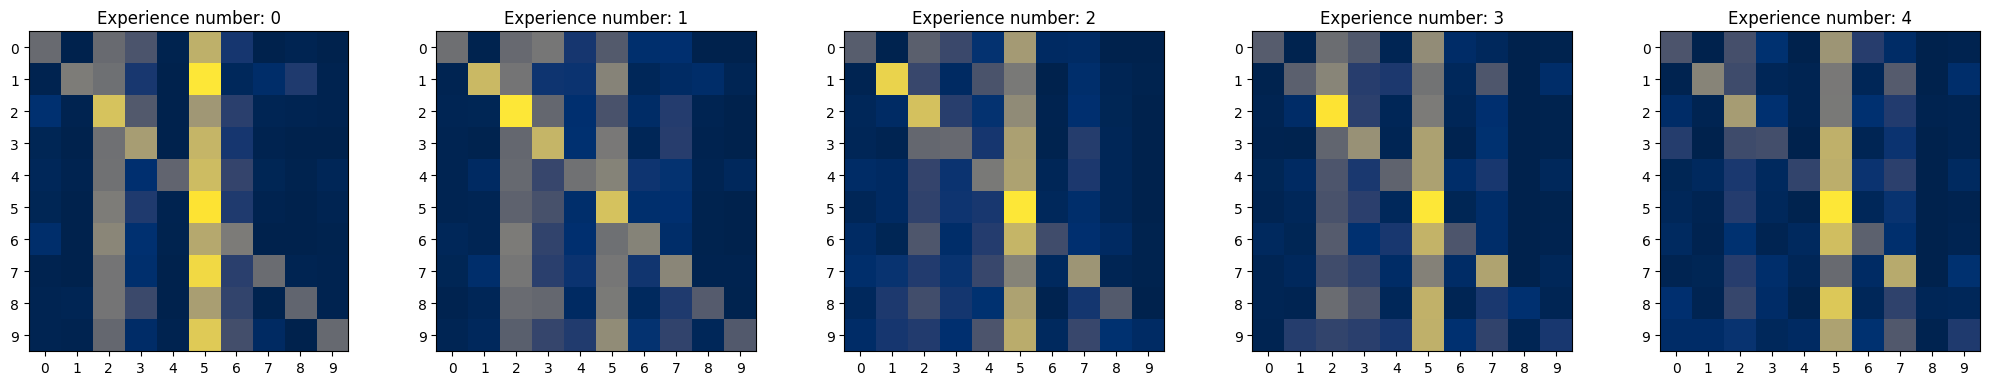

In [ ]:
NI_CWR_CF_matrix = []

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(1, 5, i+1)
  df = pd.DataFrame(r['ConfusionMatrix_Stream/eval_phase/test_stream'])
  df.drop(df.index[10:], inplace = True)
  df.drop(df.iloc[:, 10:], axis = 1, inplace = True)
  NI_CWR_CF_matrix.append(df)
  plt.imshow(df, cmap = 'cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_CWR_CF. pdf", format = "pdf")
fig.tight_layout(h_pad = -50, w_pad = 5)
plt.show()

In [ ]:
# The ExperienceForgetting metric, describing the accuracy loss
# detected for a certain experience.
# This plugin metric, computed separately for each experience,
# is the difference between the accuracy result obtained after
# first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.



# The StreamForgetting metric, describing the average evaluation accuracy loss
# detected over all experiences observed during training.
# This plugin metric, computed over all observed experiences during training,
# is the average over the difference between the accuracy result obtained
# after first training on a experience and the accuracy result obtained
# on the same experience at the end of successive experiences.

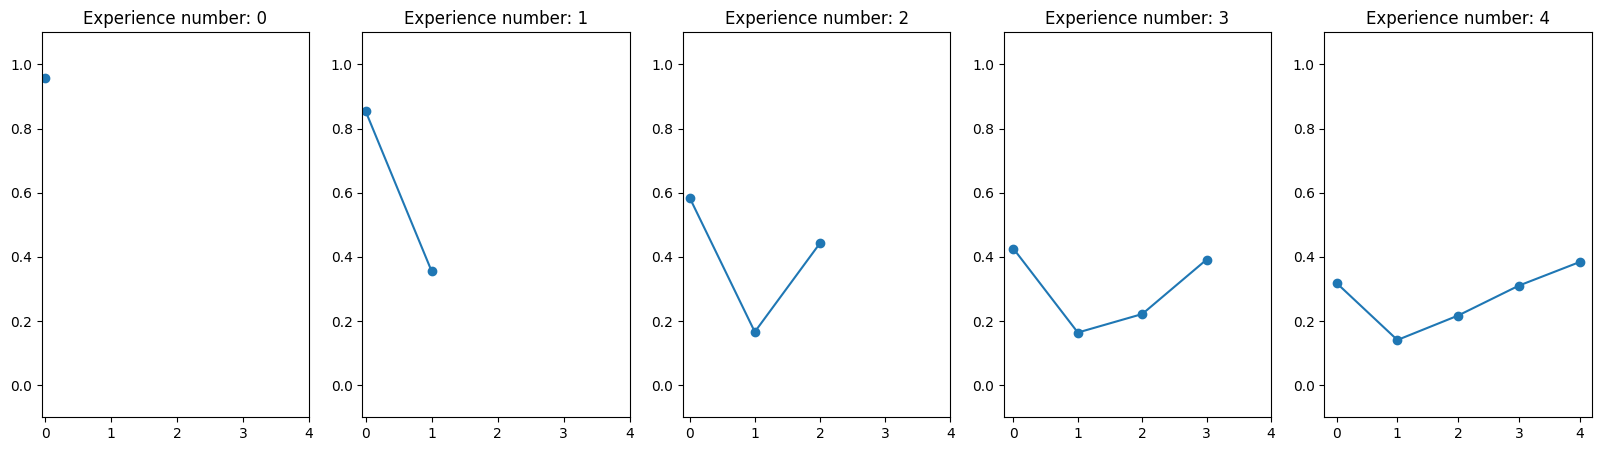

In [ ]:
NI_CWR_ACC_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    NI_CWR_ACC_matrix.append(acc)

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_CWR_ACC_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(5)))
  fig.set_facecolor('white')

plt.savefig(f"{images_dir}/NI_CWR_ACC. pdf", format = "pdf")
plt.show()

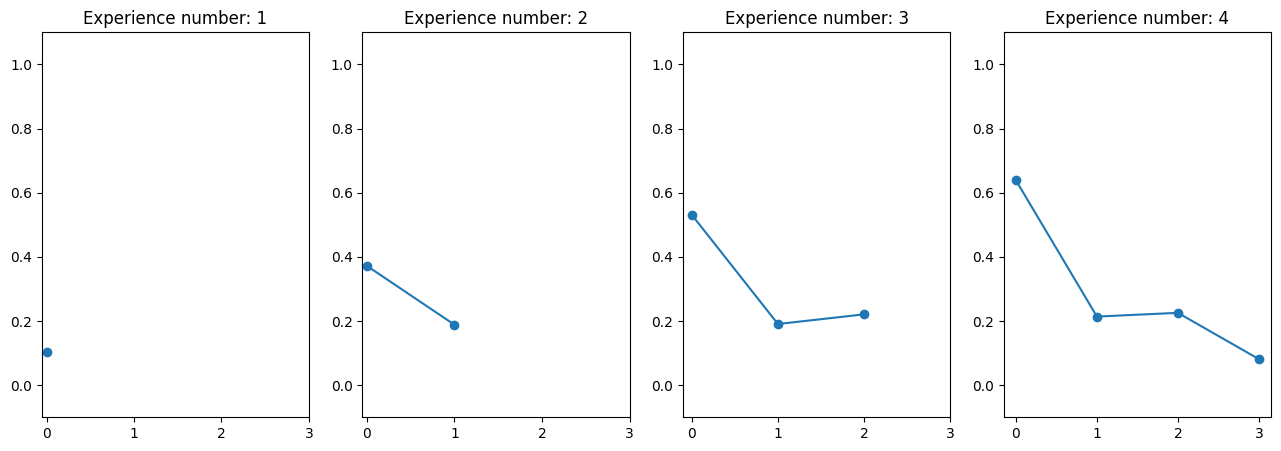

In [ ]:
NI_CWR_FORG_matrix = []

i = 0

for r in results:
    forg = [r[key] for key in forg_keys[:i]]
    NI_CWR_FORG_matrix.append(forg)
    i = i + 1

NI_CWR_FORG_matrix = NI_CWR_FORG_matrix[1:10]

fig = plt.figure(figsize = (20,5))
for i,r in enumerate(NI_CWR_FORG_matrix):
  plt.subplot(1,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i+1)))
  plt.xticks(list(range(0,4)))
  fig.set_facecolor('white')
plt.savefig(f"{images_dir}/NI_CWR_FORG. pdf", format = "pdf")
plt.show()

### Results

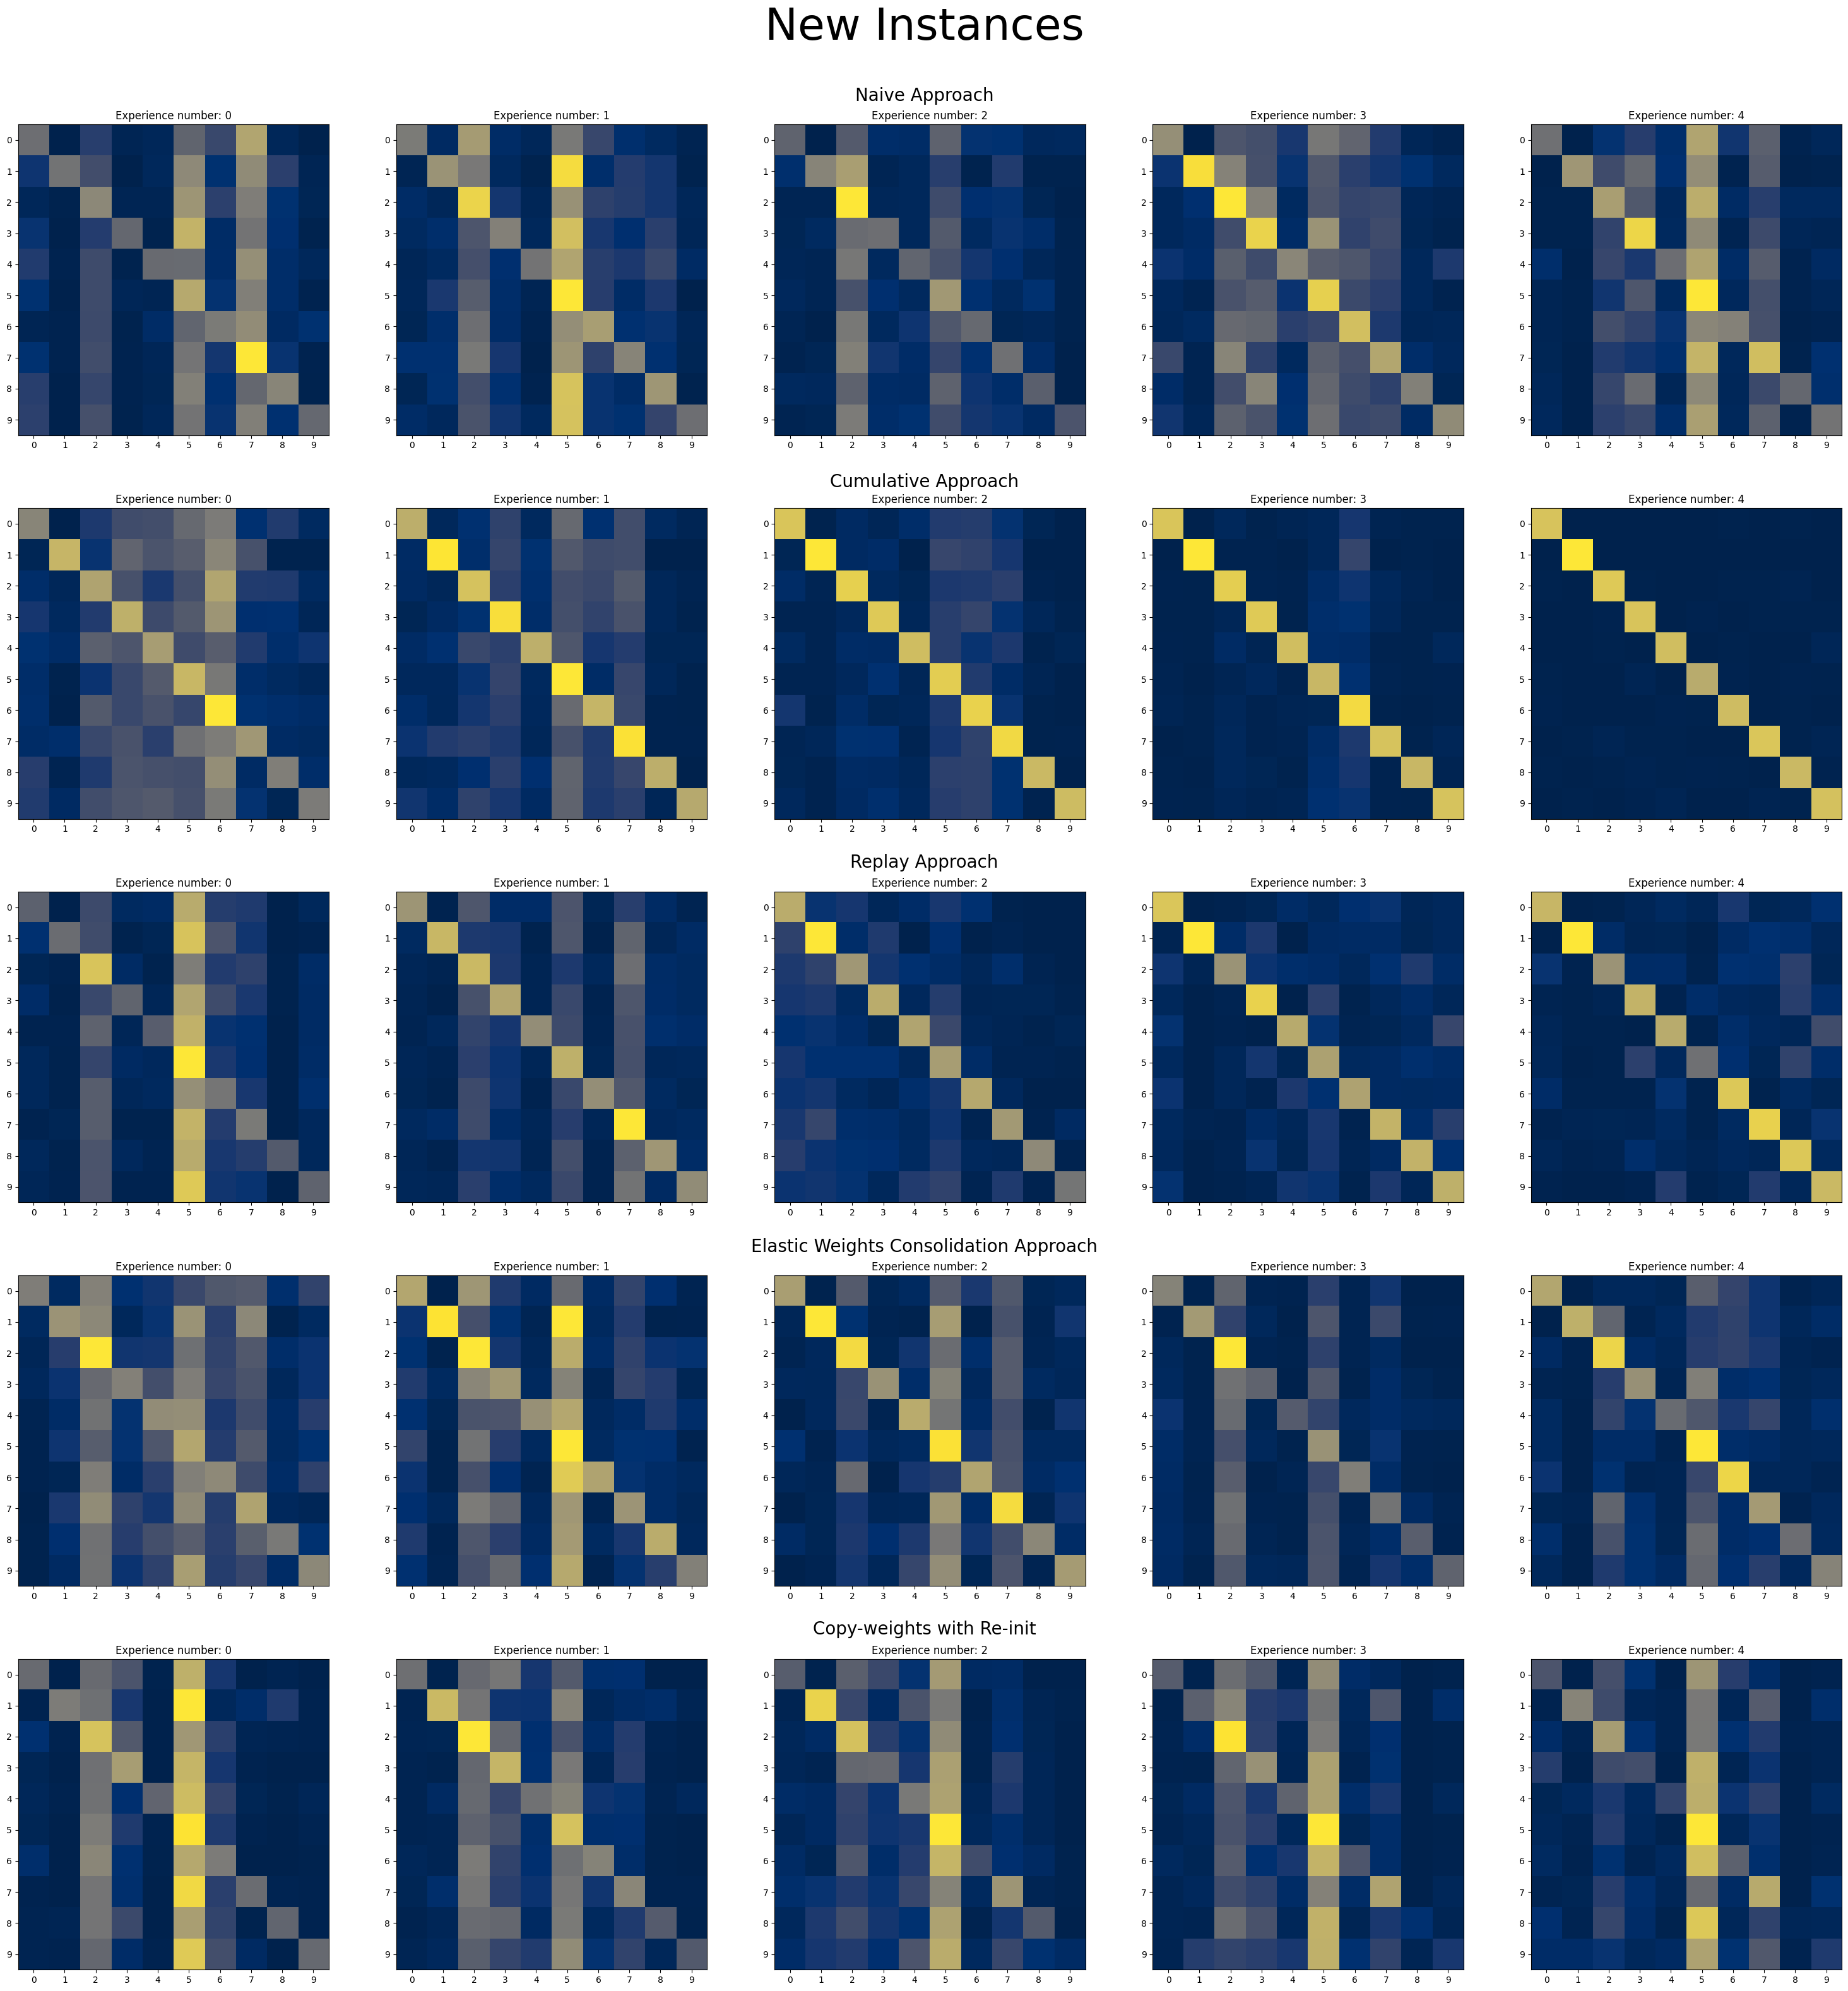

In [ ]:
CF_PLOT = []
CF_PLOT.append(NI_NA_CF_matrix)
CF_PLOT.append(NI_CA_CF_matrix)
CF_PLOT.append(NI_RA_CF_matrix)
CF_PLOT.append(NI_EWC_CF_matrix)
CF_PLOT.append(NI_CWR_CF_matrix)

fig = plt.figure(figsize = (30,30))

n_col = len(CF_PLOT)
n_row = len(CF_PLOT[0])

k = 0
for j in range(0, n_col):
  for i in range(0, n_row):
    k = k+1
    plt.subplot(n_col, n_row, k)
    plt.imshow(CF_PLOT[j][i], cmap = 'cividis', interpolation = 'none')
    plt.title("Experience number: {}".format(str(i)))
    plt.xticks(list(range(10)))
    plt.yticks(list(range(10)))
    fig.set_facecolor('white')

fig.text(.5, 1, labels[0], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.796, labels[1], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.595, labels[2], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.392, labels[3], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.text(.5, 0.19, labels[4], fontsize = 20, transform = fig.transFigure, horizontalalignment = 'center')
fig.tight_layout(h_pad = 5, w_pad = 2)
fig.suptitle('New Instances', y = 1.05, fontsize = 50, fontweight = 'roman')
plt.savefig(f"{images_dir}/NI_CF.pdf", format = "pdf")
plt.show()

In [ ]:
ACC_PLOT = []
ACC_PLOT.append(NI_NA_ACC_matrix)
ACC_PLOT.append(NI_CA_ACC_matrix)
ACC_PLOT.append(NI_RA_ACC_matrix)
ACC_PLOT.append(NI_EWC_ACC_matrix)
ACC_PLOT.append(NI_CWR_ACC_matrix)

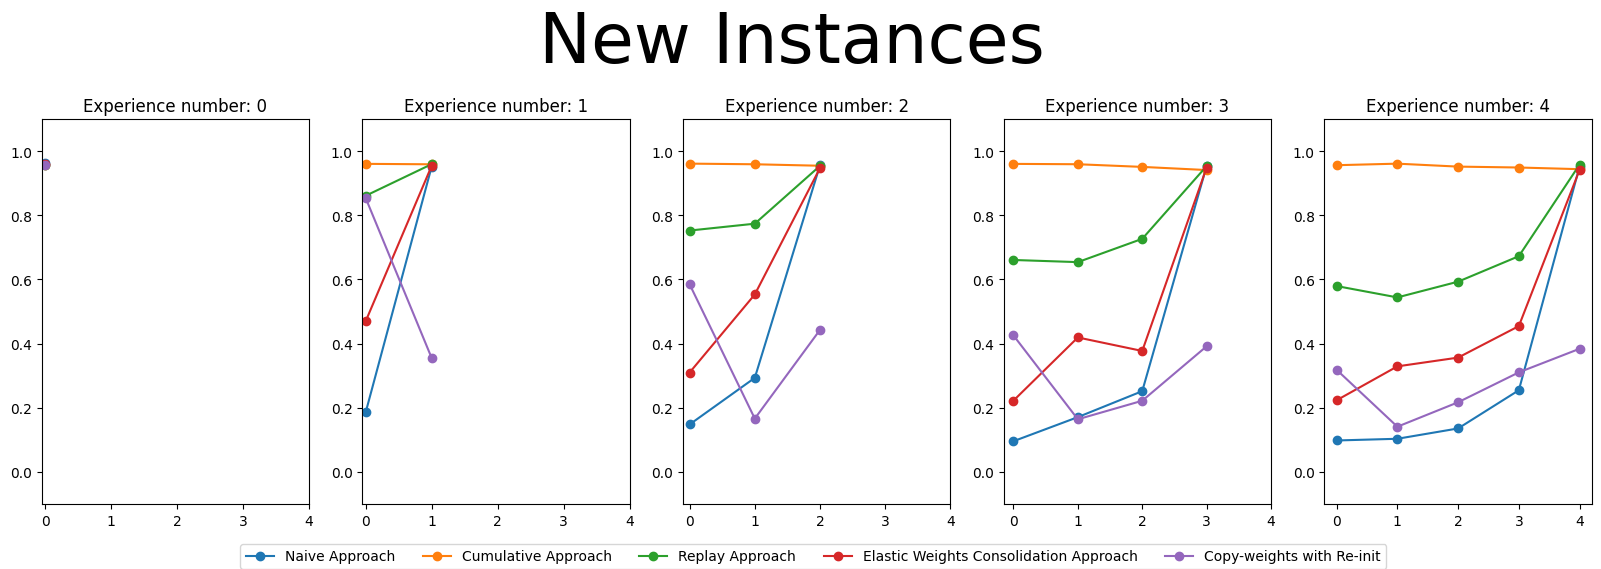

In [ ]:
fig = plt.figure(figsize = (20,5))
for j in range(0, len(ACC_PLOT)):

  for i,r in enumerate(ACC_PLOT[j]):
    plt.subplot(1,5,i+1)
    plt.plot(r[:i+1], 'o-')
    plt.ylim(-0.1,1.1)
    plt.title("Experience number: {}".format(str(i)))
    plt.xticks(list(range(5)))

    fig.set_facecolor('white')

plt.figlegend(labels, loc = (0.15, 0), ncol = 5, labelspacing = 0.)
fig.suptitle('New Instances', y = 1.1, fontsize = 50, fontweight = 'roman')
plt.savefig(f"{images_dir}/NI_ACC. pdf", format = "pdf")
plt.show()

In [ ]:
FORG_PLOT = []
FORG_PLOT.append(NI_NA_FORG_matrix)
FORG_PLOT.append(NI_CA_FORG_matrix)
FORG_PLOT.append(NI_RA_FORG_matrix)
FORG_PLOT.append(NI_EWC_FORG_matrix)
FORG_PLOT.append(NI_CWR_FORG_matrix)

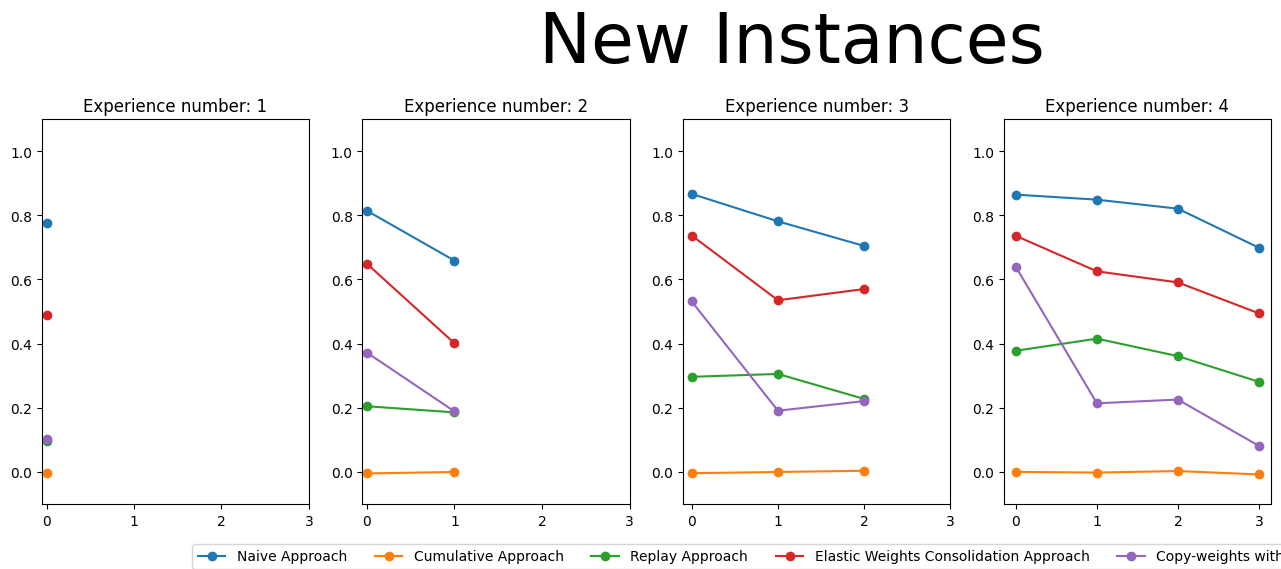

In [ ]:
fig = plt.figure(figsize = (20,5))
for j in range(0, len(FORG_PLOT)):

  for i,r in enumerate(FORG_PLOT[j]):
    plt.subplot(1,5,i+1)
    plt.plot(r[:i+1], 'o-')
    plt.ylim(-0.1,1.1)
    plt.title("Experience number: {}".format(str(i+1)))
    plt.xticks(list(range(4)))

    fig.set_facecolor('white')

plt.figlegend(labels, loc = (0.15, 0), ncol = 5, labelspacing = 0.)
fig.suptitle('New Instances', y = 1.1, fontsize = 50, fontweight = 'roman')
plt.savefig(f"{images_dir}/NI_FORG. pdf", format = "pdf")
plt.show()

## Conclusions
---

<p align = 'justify'> As seen form the previos plots, we reach different but similar results for each section.
For the <b>New Classes</b> section the best solution to overmcome forgetting is the <i>Replay Approach</i>, so simple but very effective. The <i>EWC Approach</i> and <i>CWR Approach</i> had similar bad results, but why is that? This could be because of the chosen task, in this case we were wroking on a class incremental problem with the SplitMNIST benchmark dataset, this means that for these two strategies the model during the training phase is allowed to see only one class at a time for each experience. Therefore, it can decide to focus on features of the handwritten digits that are relevant to a single class but not globally, thus disrupting the proper functioning of the aforementioned algorithms. Indeed, EWC works on finding the relevant weights of the learned class, and in CWR we hypothesize that some layers store common knowledge across the classes about the given task. However, if the features that the model focuses on are not so relevant, then EWC cannot add the loss to the correct weights, and in CWR, we may freeze layers that contain knowledge relevant to only one class.

<p align = 'jusitfy'> For the <b>New Instances</b> section the conclusions are similar, the best strategy is the <i>Replay Approach</i> and the worst are the <i>EWC Approach</i> and the <i>CWR Approach</i>. However, in this case for EWC it could be bacause the hyperparameters are not set to their optimal values. But they yeld better results then in the previous section, this could be because the 10 classes are always seen together from the model, givin a global view of the task.
An issues that comes forward in this section is the presence of light up column in the confusion matrixes even in the Cumulative Approach, this could be because of the dataset. This PermutedMNIST dataset is a simple dataset that let us work on the New Instances task, but for how it is generated it could present some issues. The shift in representation of the digits is quite abrupt and random, aspect that is not true for real objects, for real datasets the change is smoother and it usually mantain a well defined structure. So, when we randomize the permutation of the pictures we may generate a new representation that is completely random, hence ruining the ability of the network to distinguish the digits correctly.